# Setup

### Facer

In [1]:
!pip install git+https://github.com/FacePerceiver/facer.git@main
!pip install timm

  Cloning https://github.com/FacePerceiver/facer.git (to revision main) to /tmp/pip-req-build-rmxbgbq8
  Running command git clone --filter=blob:none --quiet https://github.com/FacePerceiver/facer.git /tmp/pip-req-build-rmxbgbq8
  Encountered 16 file(s) that should have been pointers, but weren't:
        samples/data/fire.webp
        samples/data/girl.jpg
        samples/data/sideface.jpg
        samples/data/twogirls.jpg
        samples/data/weirdface.jpg
        samples/data/weirdface2.jpg
        samples/data/weirdface3.jpg
        samples/download.ipynb
        samples/example_output/alignment.png
        samples/example_output/detect.png
        samples/example_output/parsing.png
        samples/face_alignment.ipynb
        samples/face_attribute.ipynb
        samples/face_detect.ipynb
        samples/face_parsing.ipynb
        samples/transform.ipynb
  Resolved https://github.com/FacePerceiver/facer.git to commit f0dd2d67def16445454b90a191cc763431795979
  Preparing metadata (se

In [2]:
!pip install pyfacer

### Library



import cv2
import os
import zipfile
import shutil
import facer
import numpy as np
asarray = np.asarray
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from PIL import Image
from mlxtend.plotting import plot_decision_regions
from IPython.display import clear_output
from sklearn.decomposition import PCA
import random
import time
import colorsys
import PIL
import tensorflow as tf
import math
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity # Example: import euclidean_distances
from sklearn.neighbors import BallTree # This line is changed
from mpl_toolkits.mplot3d import Axes3D
BallTree.valid_metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import glob
from sklearn.utils import shuffle
import tqdm

In [3]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
import cv2

# Colors

In [4]:
# Authority: https://icolorpalette.com/

# Blond
canonicalBlond = "C2A269"
canonicalDarkBlond = "91723a"
_BlondColors = set([
    canonicalBlond
])
_darkBlondColors = set([
    canonicalDarkBlond
])

# Brown
canonicalBrown = "5C4033"
canonicalDarkBrown = "34241d"
_BrownColors = set([
    canonicalBrown
])
_darkBrownColors = set([
    canonicalDarkBrown
])

# Black hair
canonicalBlack = "000000"
_blackColors = set([
    canonicalBlack
])

# Red hair
canonicalRed = "681a1a"
_redColors = set([
    canonicalRed
])


# Grey hair
canonicalGrey = "515151"
_greyColors = set([
    canonicalGrey
])



In [5]:
# Final colorSpaces dictionary
colorSpaces = {
    "black": _blackColors,
    "brown": _BrownColors,
    "dark_brown": _darkBrownColors,
    "blonde": _BlondColors,
    "dark_blonde": _darkBlondColors,
    "red": _redColors,
    "grey": _greyColors
}

# Output the hair color categories this program classifies
print(f"This program classifies into {colorSpaces.keys()}")

This program classifies into dict_keys(['black', 'brown', 'dark_brown', 'blonde', 'dark_blonde', 'red', 'grey'])


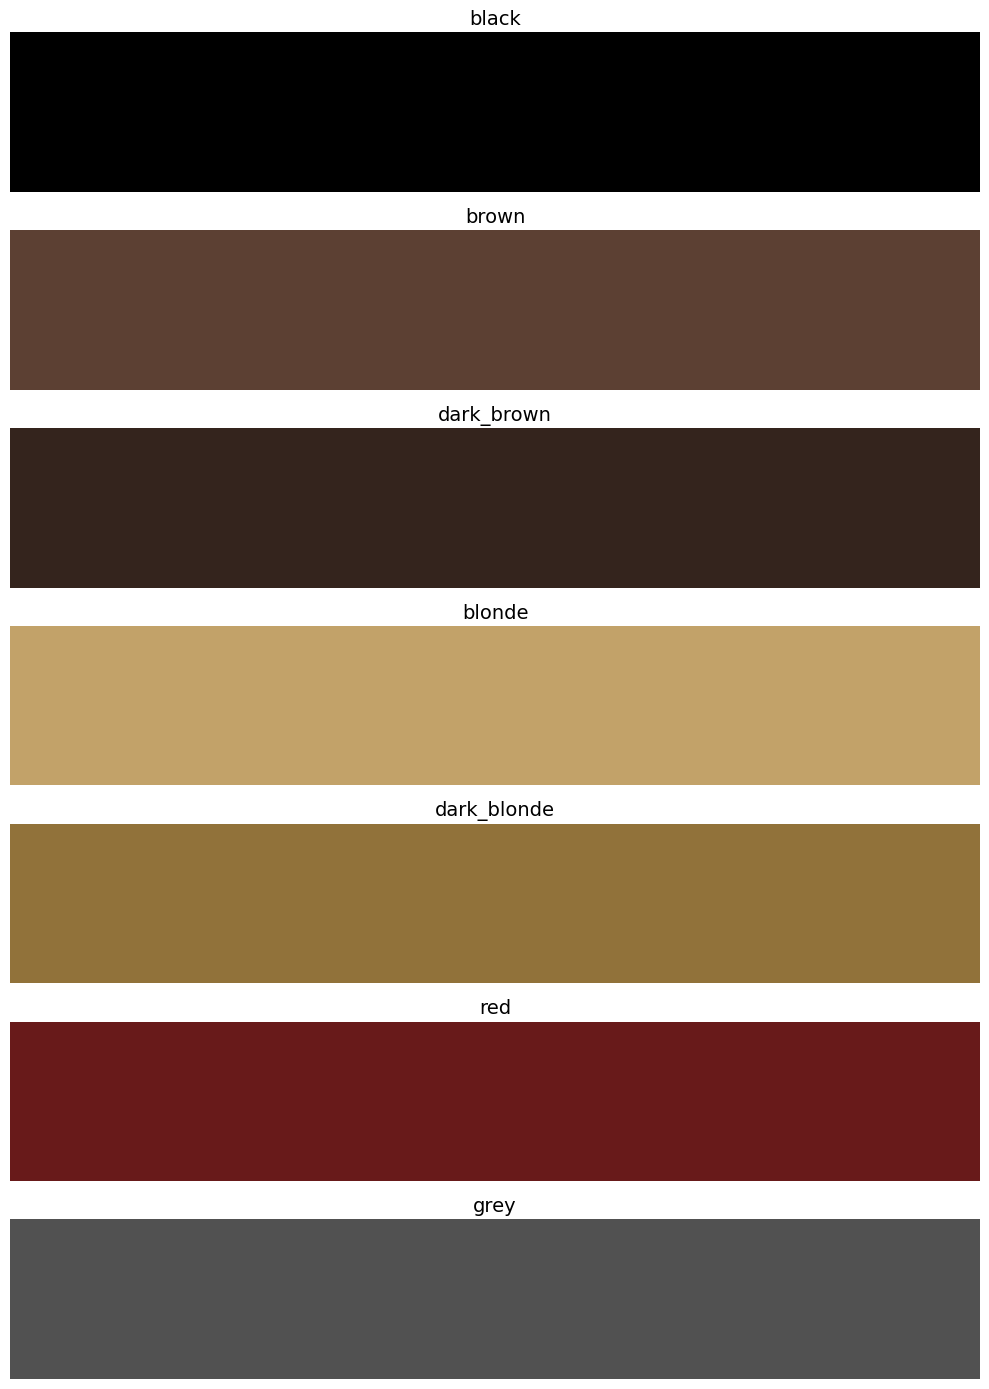

In [6]:
import matplotlib.pyplot as plt
# Convert hex colors to RGB and plot them
def hex_to_rgb(hex_str):
    """Convert hex color to RGB tuple."""
    hex_str = hex_str.lstrip('#')  # Remove the '#' if present
    return tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))

# Plot function updated to handle RGB conversion
def plot_colors(color_dict):
    # Define the number of categories
    num_categories = len(color_dict)
    fig, ax = plt.subplots(num_categories, 1, figsize=(10, 2 * num_categories))

    # Iterate through each color category and plot
    for i, (category, colors) in enumerate(color_dict.items()):
        color_list = [hex_to_rgb(color) for color in colors]
        # Normalize the color values to be between 0 and 1 (required for plotting)
        color_list = [(r/255, g/255, b/255) for r, g, b in color_list]
        ax[i].imshow([color_list], aspect="auto")
        ax[i].set_title(category, fontsize=14)
        ax[i].axis("off")  # Disable axis

    plt.tight_layout()
    plt.show()

# Assuming colorSpaces is the dictionary you want to plot
plot_colors(colorSpaces) # Changed colors_dict to colorSpaces

# **Steps to Implement:**
1.   Segment the Hair: Utilize the segmented image you already have.

2.   Extract Pixel Colors: Gather all pixel color data within the segmented hair area.

3.   Calculate Average and Dominant Colors:
*   Average Color: Compute the average RGB values for all hair pixels.
*   Dominant Color: Use a clustering method (like K-means) to find the most frequent color(s).

4.   Color Distance Calculation:
*   Calculate the Euclidean distance between the extracted average and dominant colors and each color category.
*   Find the closest match.



In [7]:
import facer
import torch

def segment_and_extract_hair(image_path):
    """
    Function to segment the hair from an image and display it with its original colors.

    Parameters:
    - image_path: The path to the input image

    Returns:
    - masked_image: The image with the hair segmented and displayed with its original colors
    """

    # Step 1: Set up the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 2: Load and process the image using facer
    image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=device)  # image: 1 x 3 x h x w

    # Step 3: Initialize face detector and parser models
    face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    face_parser = facer.face_parser('farl/lapa/448', device=device)

    # Step 4: Perform face detection
    with torch.inference_mode():
        faces = face_detector(image)

    # Step 5: Perform face parsing to get segmentation
    with torch.inference_mode():
        faces = face_parser(image, faces)

    # Step 6: Extract segmentation logits from parsed faces
    seg_logits = faces['seg']['logits']
    seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

    # Step 7: Extract the hair segment (class 10 corresponds to hair in this segmentation model)
    hair_segment_image = (seg_probs[:, 10, :, :] > 0.5).float() * 255  # Thresholding to get the hair mask

    # Step 8: Create the mask for the hair segment
    hair_mask = (seg_probs[:, 10, :, :] > 0.5).unsqueeze(1)  # Add channel dimension to match the image shape

    # Step 9: Apply the hair mask to the original image to retain the original hair colors
    masked_image = image * hair_mask  # Retain hair colors by applying the mask to the image

    # Step 10: Display the masked image with the original hair colors
    facer.show_bchw(masked_image)  # Display the result using facer

    return masked_image


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_lab(rgb_color):
    """Convert RGB tuple to LAB tuple."""
    rgb_normalized = np.array(rgb_color) / 255.0  # Normalize to 0-1
    lab_color = color.rgb2lab([[rgb_normalized]])[0][0]
    return tuple(lab_color)

def hex_to_lab(hex_color):
    """Convert hex color to LAB tuple."""
    rgb_color = hex_to_rgb(hex_color)
    return rgb_to_lab(rgb_color)

In [9]:
def extract_hair_colors(masked_image_tensor):
    """Extract all pixel colors from the segmented image."""
    image_np = masked_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    non_black_pixels = image_np[(image_np[:, :, 0] > 0) | (image_np[:, :, 1] > 0) | (image_np[:, :, 2] > 0)]
    return non_black_pixels

def calculate_average_color(colors):
    """Calculate the average color of a list of RGB tuples."""
    return tuple(np.mean(colors, axis=0).astype(int))

def calculate_dominant_color(colors, n_clusters=3):
    """Use K-means clustering to find the dominant color."""
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(colors)
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    return tuple(dominant_color.astype(int))


In [10]:
def calculate_color_distance_lab(color1_lab, color2_lab):
    """Calculate the Euclidean distance between two LAB colors."""
    return distance.euclidean(color1_lab, color2_lab)


def compare_with_color_sets(avg_color_rgb, dominant_color_rgb, color_spaces):
    """Compare average and dominant colors to predefined color sets in LAB space."""
    avg_color_lab = rgb_to_lab(avg_color_rgb)
    dominant_color_lab = rgb_to_lab(dominant_color_rgb)

    avg_distance_dict = {}
    dominant_distance_dict = {}

    for color_category, color_set in color_spaces.items():
        distances = []
        for hex_color in color_set:
            color_lab = hex_to_lab(hex_color)
            avg_distance = calculate_color_distance_lab(avg_color_lab, color_lab)
            dominant_distance = calculate_color_distance_lab(dominant_color_lab, color_lab)
            distances.append((avg_distance, dominant_distance))

        min_avg_distance = min(distances, key=lambda x: x[0])[0]
        min_dominant_distance = min(distances, key=lambda x: x[1])[1]

        avg_distance_dict[color_category] = min_avg_distance
        dominant_distance_dict[color_category] = min_dominant_distance

    return avg_distance_dict, dominant_distance_dict

In [11]:
def get_closest_color_category(avg_distance_dict, dominant_distance_dict):
    """Determine the closest color category based on average and dominant distances."""
    combined_distances = {
        category: (avg_distance_dict[category] + dominant_distance_dict[category]) / 2
        for category in avg_distance_dict
    }

    closest_category = min(combined_distances, key=combined_distances.get)
    return closest_category

In [12]:
# Main Function to Segment and Classify Hair Color
def Classify_hair(image_path, color_spaces):
    """
    Segment the hair from an image, calculate color metrics, and classify.

    Parameters:
    - image_path: Path to the input image.
    - color_spaces: Dictionary of predefined color sets.

    Returns:
    - Closest color classification.
    """
    # Step 1: Segment the hair
    masked_image = segment_and_extract_hair(image_path)

    # Step 2: Extract colors from the segmented image
    hair_colors = extract_hair_colors(masked_image)

    # Step 3: Calculate average and dominant colors
    average_color = calculate_average_color(hair_colors)
    dominant_color = calculate_dominant_color(hair_colors)

    # Step 4: Compare with color sets
    avg_distances, dominant_distances = compare_with_color_sets(average_color, dominant_color, color_spaces)

    # Step 5: Determine the closest color category
    closest_color = get_closest_color_category(avg_distances, dominant_distances)

    # Output the results
    print(f"Average Color (RGB): {average_color}")
    print(f"Dominant Color (RGB): {dominant_color}")
    print("Color Comparison Results:")
    for category in avg_distances:
        print(f"{category} - Avg Distance: {avg_distances[category]}, Dominant Distance: {dominant_distances[category]}")
    print(f"The closest color classification is: {closest_color}")

    return closest_color

# Evaluation

### TEST


In [ ]:
image_path = "/content/test1.jpg"
closest_color = Classify_hair(image_path, colorSpaces)

In [13]:
import os
import pandas as pd
import zipfile
from sklearn.metrics import classification_report, accuracy_score

In [16]:
# Define paths
zip_file_path = '/content/Hair_Data.zip'
extracted_dir = '/content/extracted_Hair_Data'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
print("Files extracted to:", extracted_dir)


Files extracted to: /content/extracted_Hair_Data


In [17]:
# Check contents of the extracted directory
print("Contents of extracted directory:")
for folder_name in os.listdir(extracted_dir):
    print("Folder:", folder_name)


Contents of extracted directory:
Folder: Hair_Data


Processing folder: Black
Processing image: 000007.jpg


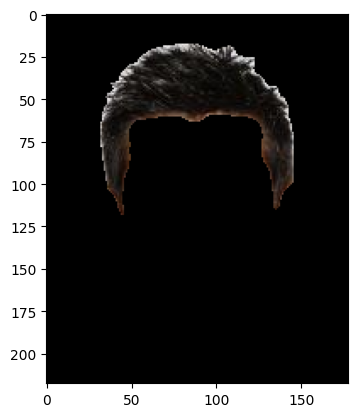

Average Color (RGB): (49, 42, 38)
Dominant Color (RGB): (26, 21, 17)
Color Comparison Results:
black - Avg Distance: 18.245668159922776, Dominant Distance: 8.03735359764941
brown - Avg Distance: 17.097190228745355, Dominant Distance: 26.120727693165865
dark_brown - Avg Distance: 5.882567447956757, Dominant Distance: 10.926699560998152
blonde - Avg Distance: 58.92368109370196, Dominant Distance: 68.42552304086873
dark_blonde - Avg Distance: 45.11989992458497, Dominant Distance: 53.52063650703759
red - Avg Distance: 36.547433446299834, Dominant Distance: 40.33469663838707
grey - Avg Distance: 17.356984894662666, Dominant Distance: 27.494039114784485
The closest color classification is: dark_brown
Processing image: pexels-hannah-nelson-390257-1086579.jpg


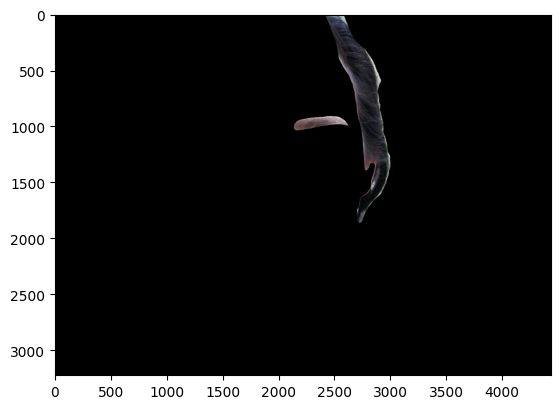

Average Color (RGB): (60, 57, 63)
Dominant Color (RGB): (33, 33, 38)
Color Comparison Results:
black - Avg Distance: 24.825967465446073, Dominant Distance: 13.418893544782728
brown - Avg Distance: 18.57429849784735, Dominant Distance: 25.079041243494576
dark_brown - Avg Distance: 14.3744419925068, Dominant Distance: 12.51713344156928
blonde - Avg Distance: 57.49243917056726, Dominant Distance: 66.8082508700135
dark_blonde - Avg Distance: 46.203522603597754, Dominant Distance: 53.60037146248495
red - Avg Distance: 39.7200805737638, Dominant Distance: 42.041973816078354
grey - Avg Distance: 10.834458039792654, Dominant Distance: 21.823748073820887
The closest color classification is: dark_brown
Processing image: 000008765.jpg


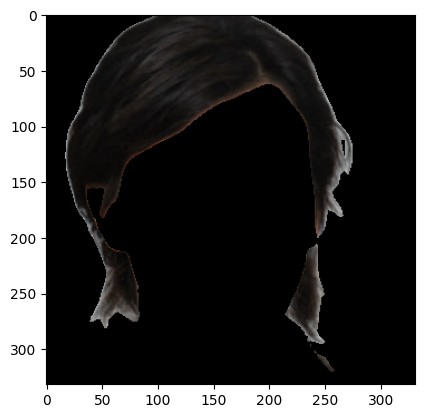

Average Color (RGB): (35, 32, 31)
Dominant Color (RGB): (22, 19, 18)
Color Comparison Results:
black - Avg Distance: 12.652150729312979, Dominant Distance: 6.323848044574834
brown - Avg Distance: 22.76673903328047, Dominant Distance: 28.041820423498603
dark_brown - Avg Distance: 8.993924177547989, Dominant Distance: 12.959044312597396
blonde - Avg Distance: 64.72125170685244, Dominant Distance: 70.38102945121716
dark_blonde - Avg Distance: 50.72661306831055, Dominant Distance: 55.71241688088775
red - Avg Distance: 39.8434292508329, Dominant Distance: 42.10573512339038
grey - Avg Distance: 21.978383763222002, Dominant Distance: 28.35131116815734
The closest color classification is: black
Processing image: pexels-andy-lee-1453672476-28845478.jpg


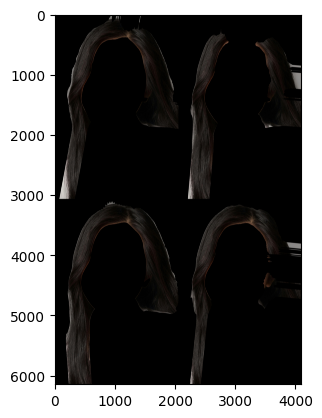

Error processing /content/extracted_Hair_Data/Hair_Data/Black/pexels-andy-lee-1453672476-28845478.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3
Processing image: pexels-urfriendlyphotog-24362258.jpg


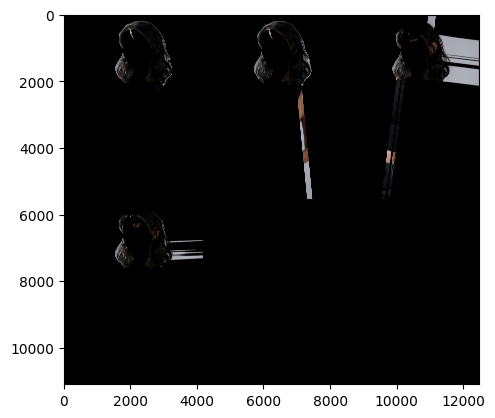

Error processing /content/extracted_Hair_Data/Hair_Data/Black/pexels-urfriendlyphotog-24362258.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3
Processing image: 000055.jpg


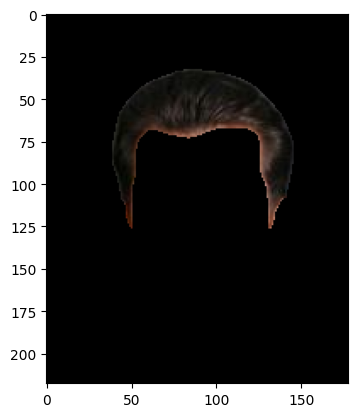

Average Color (RGB): (40, 32, 26)
Dominant Color (RGB): (22, 20, 15)
Color Comparison Results:
black - Avg Distance: 14.348766018827924, Dominant Distance: 7.077707038544869
brown - Avg Distance: 19.925744369286136, Dominant Distance: 27.49008401289931
dark_brown - Avg Distance: 5.249874881645209, Dominant Distance: 12.456849420602104
blonde - Avg Distance: 62.19856318689615, Dominant Distance: 69.31011189062555
dark_blonde - Avg Distance: 47.48587758665658, Dominant Distance: 54.40939081876231
red - Avg Distance: 36.54079225477158, Dominant Distance: 42.110363723842156
grey - Avg Distance: 22.332122773596588, Dominant Distance: 28.250444829619727
The closest color classification is: dark_brown
Processing image: 000023.jpg


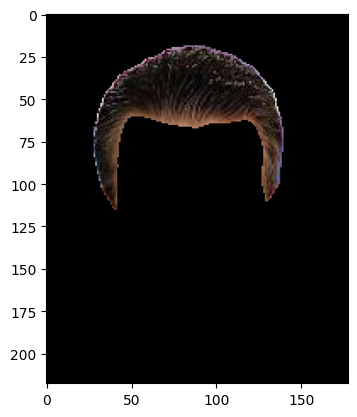

Average Color (RGB): (59, 44, 39)
Dominant Color (RGB): (30, 21, 18)
Color Comparison Results:
black - Avg Distance: 21.28831518348897, Dominant Distance: 9.365761853238677
brown - Avg Distance: 13.134131701476088, Dominant Distance: 24.839341826054646
dark_brown - Avg Distance: 4.06983573941991, Dominant Distance: 9.509429030749729
blonde - Avg Distance: 56.2523624150778, Dominant Distance: 67.77986037228632
dark_blonde - Avg Distance: 42.22391214131838, Dominant Distance: 52.8216906742485
red - Avg Distance: 32.157654196031686, Dominant Distance: 38.06108307796921
grey - Avg Distance: 17.12486958930738, Dominant Distance: 27.238411989400685
The closest color classification is: dark_brown
Processing image: pexels-urfriendlyphotog-27786116.jpg


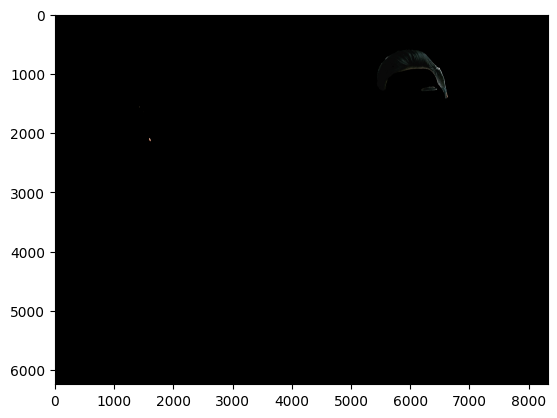

Error processing /content/extracted_Hair_Data/Hair_Data/Black/pexels-urfriendlyphotog-27786116.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3
Processing image: b1.jpeg


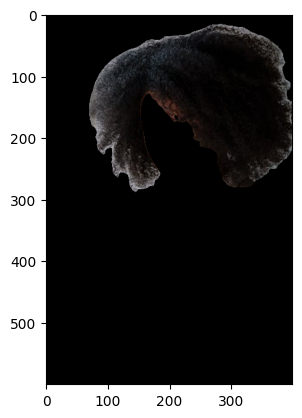

Average Color (RGB): (28, 25, 25)
Dominant Color (RGB): (12, 9, 8)
Color Comparison Results:
black - Avg Distance: 9.227186694070655, Dominant Distance: 2.7948596369547354
brown - Avg Distance: 25.695394671175762, Dominant Distance: 31.338096486885487
dark_brown - Avg Distance: 11.046869823116829, Dominant Distance: 16.07944735126596
blonde - Avg Distance: 68.0201562984836, Dominant Distance: 73.6864592888551
dark_blonde - Avg Distance: 53.71901380643367, Dominant Distance: 58.763382890880266
red - Avg Distance: 40.95747796583059, Dominant Distance: 44.10307530936043
grey - Avg Distance: 25.408179982779924, Dominant Distance: 31.838655880363937
The closest color classification is: black
Processing image: 000345.jpg


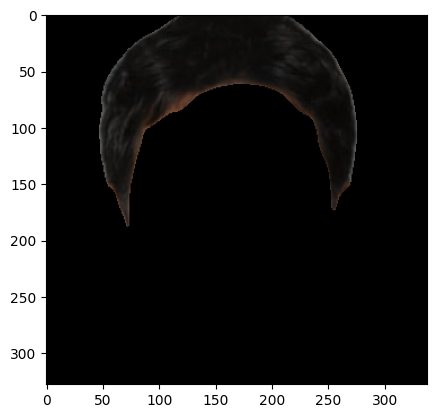

Average Color (RGB): (25, 22, 20)
Dominant Color (RGB): (16, 15, 14)
Color Comparison Results:
black - Avg Distance: 7.782184019657369, Dominant Distance: 4.4124732645181295
brown - Avg Distance: 26.607995658955595, Dominant Distance: 30.031072653391607
dark_brown - Avg Distance: 11.606540050961055, Dominant Distance: 14.911072415026558
blonde - Avg Distance: 68.82563304116638, Dominant Distance: 72.19733887322006
dark_blonde - Avg Distance: 54.18205418670105, Dominant Distance: 57.45377559047328
red - Avg Distance: 41.31291196003291, Dominant Distance: 43.75536324227492
grey - Avg Distance: 27.02535372553365, Dominant Distance: 30.0927807377292
The closest color classification is: black
Processing image: pexels-alpha-paul-696966661-18330714.jpg


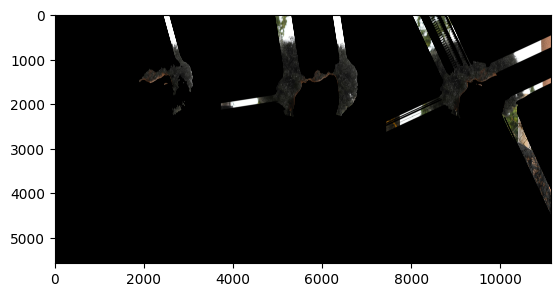

Error processing /content/extracted_Hair_Data/Hair_Data/Black/pexels-alpha-paul-696966661-18330714.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3
Processing image: bl1.jpg


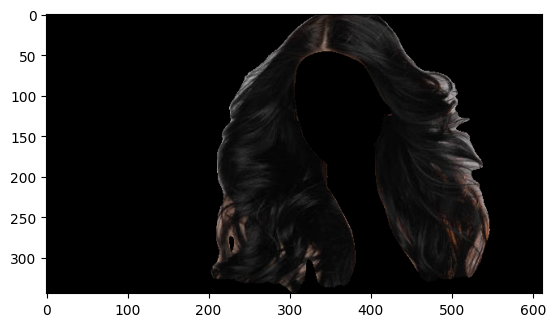

Average Color (RGB): (27, 25, 24)
Dominant Color (RGB): (15, 14, 14)
Color Comparison Results:
black - Avg Distance: 9.034836800473899, Dominant Distance: 4.056121180648336
brown - Avg Distance: 25.838495355826122, Dominant Distance: 30.454982602182554
dark_brown - Avg Distance: 11.172559139959828, Dominant Distance: 15.333302166708885
blonde - Avg Distance: 67.9314434849169, Dominant Distance: 72.70313304123452
dark_blonde - Avg Distance: 53.558733787518214, Dominant Distance: 57.992168622791034
red - Avg Distance: 41.35742140696304, Dominant Distance: 43.99181371980652
grey - Avg Distance: 25.542721610831105, Dominant Distance: 30.415063568908522
The closest color classification is: black
Processing image: 000046.jpg


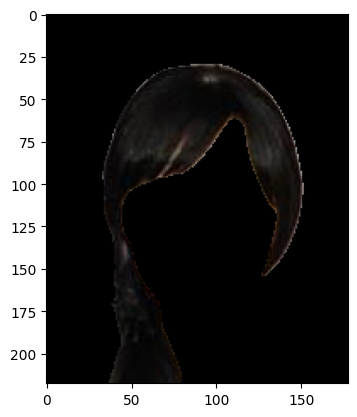

Average Color (RGB): (24, 21, 19)
Dominant Color (RGB): (14, 12, 11)
Color Comparison Results:
black - Avg Distance: 7.2958440321454585, Dominant Distance: 3.524595178657908
brown - Avg Distance: 27.05596387857193, Dominant Distance: 30.72021525498445
dark_brown - Avg Distance: 12.011366141139654, Dominant Distance: 15.515945780347417
blonde - Avg Distance: 69.28656856022205, Dominant Distance: 72.995370329979
dark_blonde - Avg Distance: 54.606821180023104, Dominant Distance: 58.154496327940606
red - Avg Distance: 41.55494988233726, Dominant Distance: 43.91801983005973
grey - Avg Distance: 27.50114742291093, Dominant Distance: 31.02687072429685
The closest color classification is: black
Processing image: 00012344.jpg


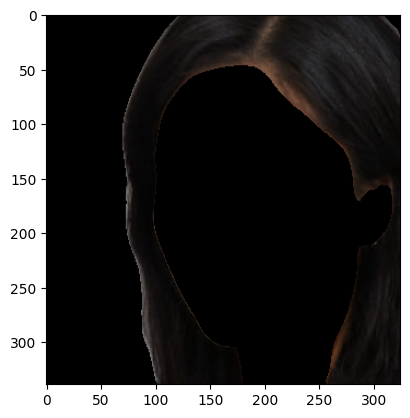

Average Color (RGB): (26, 22, 20)
Dominant Color (RGB): (14, 12, 11)
Color Comparison Results:
black - Avg Distance: 8.021502786939488, Dominant Distance: 3.524595178657908
brown - Avg Distance: 26.25318178411656, Dominant Distance: 30.72021525498445
dark_brown - Avg Distance: 11.18855171344841, Dominant Distance: 15.515945780347417
blonde - Avg Distance: 68.61345590781374, Dominant Distance: 72.995370329979
dark_blonde - Avg Distance: 53.93665772191721, Dominant Distance: 58.154496327940606
red - Avg Distance: 40.760886848003445, Dominant Distance: 43.91801983005973
grey - Avg Distance: 26.946165836213257, Dominant Distance: 31.02687072429685
The closest color classification is: black
Processing image: 0001345.jpg


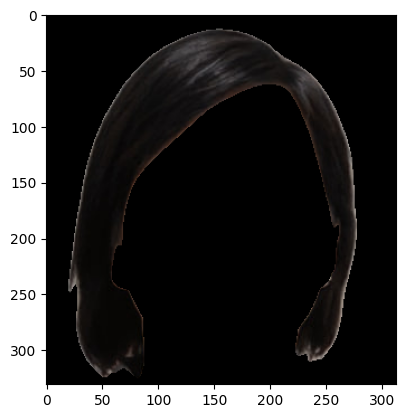

Average Color (RGB): (29, 25, 24)
Dominant Color (RGB): (17, 15, 14)
Color Comparison Results:
black - Avg Distance: 9.446937953404216, Dominant Distance: 4.540766565118342
brown - Avg Distance: 25.12367585738513, Dominant Distance: 29.78786584669261
dark_brown - Avg Distance: 10.318111607611517, Dominant Distance: 14.63620786101377
blonde - Avg Distance: 67.50536093615653, Dominant Distance: 72.04623670933458
dark_blonde - Avg Distance: 53.06785587965883, Dominant Distance: 57.279770998832994
red - Avg Distance: 40.288983287988515, Dominant Distance: 43.37616340148747
grey - Avg Distance: 25.376046768027127, Dominant Distance: 30.018549822700827
The closest color classification is: black
Processing image: pexels-kobby-katalist-1112446271-23710184.jpg


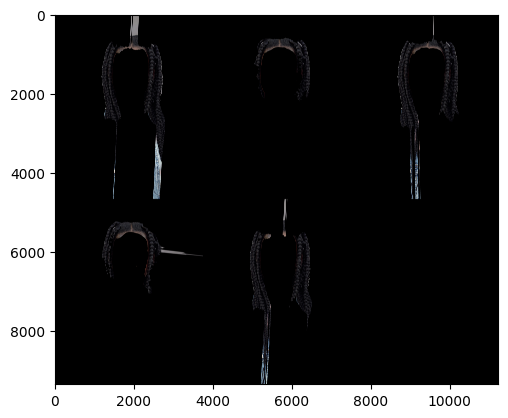

Error processing /content/extracted_Hair_Data/Hair_Data/Black/pexels-kobby-katalist-1112446271-23710184.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3
Processing image: 000008.jpg


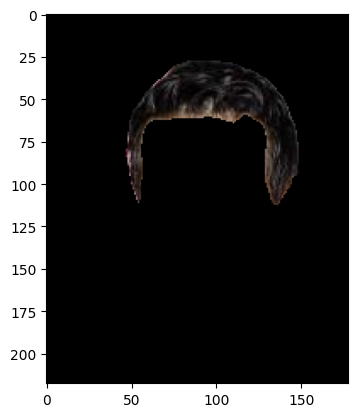

Average Color (RGB): (40, 33, 31)
Dominant Color (RGB): (18, 15, 15)
Color Comparison Results:
black - Avg Distance: 14.01101751439293, Dominant Distance: 4.704992029954942
brown - Avg Distance: 20.69614993169614, Dominant Distance: 29.657471059940264
dark_brown - Avg Distance: 6.6525315745886235, Dominant Distance: 14.502848245294242
blonde - Avg Distance: 63.1675761267817, Dominant Distance: 72.08263044608331
dark_blonde - Avg Distance: 48.99756938360779, Dominant Distance: 57.35721058753698
red - Avg Distance: 37.49187247298955, Dominant Distance: 43.0529427465097
grey - Avg Distance: 21.353462248049595, Dominant Distance: 29.917094500781268
The closest color classification is: black
Processing image: 000047.jpg


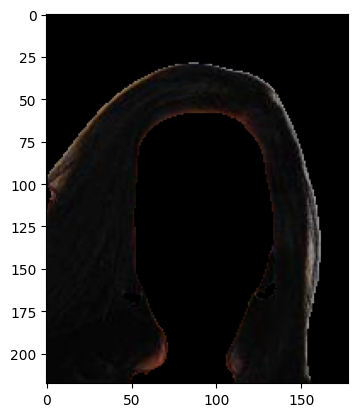

Average Color (RGB): (20, 17, 16)
Dominant Color (RGB): (12, 11, 11)
Color Comparison Results:
black - Avg Distance: 5.479892212846946, Dominant Distance: 3.100965368608174
brown - Avg Distance: 28.818731356022468, Dominant Distance: 31.29068004200954
dark_brown - Avg Distance: 13.679011734217944, Dominant Distance: 16.109427120594198
blonde - Avg Distance: 71.16698641149883, Dominant Distance: 73.5580493138287
dark_blonde - Avg Distance: 56.433552043063436, Dominant Distance: 58.76465604458013
red - Avg Distance: 42.55321044113285, Dominant Distance: 44.45292493874456
grey - Avg Distance: 29.183856038658686, Dominant Distance: 31.36899763720791
The closest color classification is: black
Processing folder: Blonde
Processing image: 000019.jpg


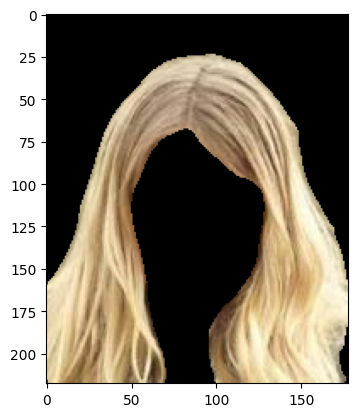

Average Color (RGB): (199, 174, 135)
Dominant Color (RGB): (236, 217, 178)
Color Comparison Results:
black - Avg Distance: 76.09130442357404, Dominant Distance: 89.96567917239106
brown - Avg Distance: 44.338224664208425, Dominant Distance: 58.94451710297573
dark_brown - Avg Distance: 58.66628453333092, Dominant Distance: 73.00781972103138
blonde - Avg Distance: 11.391266712633538, Dominant Distance: 23.00073132520645
dark_blonde - Avg Distance: 25.430963896427187, Dominant Distance: 40.07521390401396
red - Avg Distance: 58.60554768255655, Dominant Distance: 72.8642066092311
grey - Avg Distance: 44.63377320063338, Dominant Distance: 57.125494684877765
The closest color classification is: blonde
Processing image: 000013.jpg


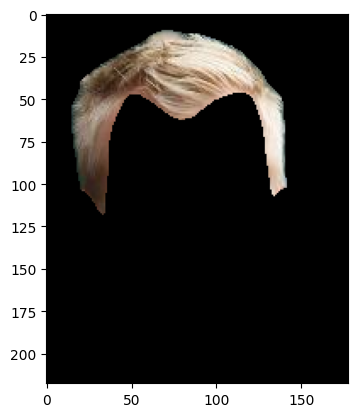

Average Color (RGB): (161, 141, 122)
Dominant Color (RGB): (161, 137, 116)
Color Comparison Results:
black - Avg Distance: 61.450215806670286, Dominant Distance: 60.796182492394834
brown - Avg Distance: 30.629470547287355, Dominant Distance: 29.273631010243765
dark_brown - Avg Distance: 44.370655575010936, Dominant Distance: 43.38877124430053
blonde - Avg Distance: 22.659552792582947, Dominant Distance: 21.608125379823495
dark_blonde - Avg Distance: 24.46384076003552, Dominant Distance: 22.376212616324253
red - Avg Distance: 48.342699947955246, Dominant Distance: 46.33137921154622
grey - Avg Distance: 28.884546588883858, Dominant Distance: 28.92524296492118
The closest color classification is: blonde
Processing image: 000029.jpg


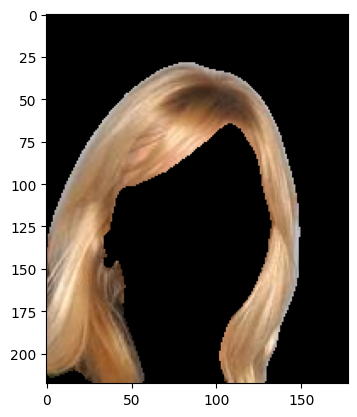

Average Color (RGB): (175, 138, 105)
Dominant Color (RGB): (176, 136, 99)
Color Comparison Results:
black - Avg Distance: 65.12986536103412, Dominant Distance: 65.78304382428176
brown - Avg Distance: 31.999855312588082, Dominant Distance: 32.47035933101385
dark_brown - Avg Distance: 46.959911437282926, Dominant Distance: 47.488847780334474
blonde - Avg Distance: 14.591153794441736, Dominant Distance: 13.413197285050794
dark_blonde - Avg Distance: 16.43844336758618, Dominant Distance: 14.481397335020313
red - Avg Distance: 44.99129810828316, Dominant Distance: 44.331961591088216
grey - Avg Distance: 35.81510626591666, Dominant Distance: 37.46698063339859
The closest color classification is: blonde
Processing image: 000054.jpg


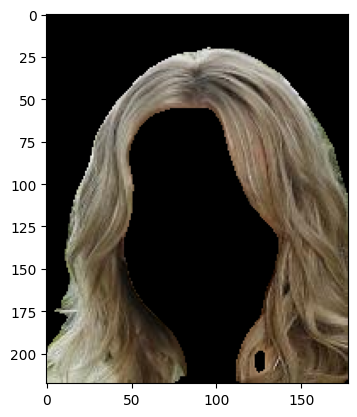

Average Color (RGB): (120, 107, 86)
Dominant Color (RGB): (125, 110, 88)
Color Comparison Results:
black - Avg Distance: 47.896709624875875, Dominant Distance: 49.46786309124316
brown - Avg Distance: 18.27789541034207, Dominant Distance: 19.25473896699575
dark_brown - Avg Distance: 30.95760617516227, Dominant Distance: 32.35413904435234
blonde - Avg Distance: 30.340678361509557, Dominant Distance: 28.74460950834884
dark_blonde - Avg Distance: 22.259580208072116, Dominant Distance: 21.17013697694496
red - Avg Distance: 40.77144815640889, Dominant Distance: 40.911212318471954
grey - Avg Distance: 17.87645079154954, Dominant Distance: 19.43334935724661
The closest color classification is: grey
Processing image: 000022.jpg


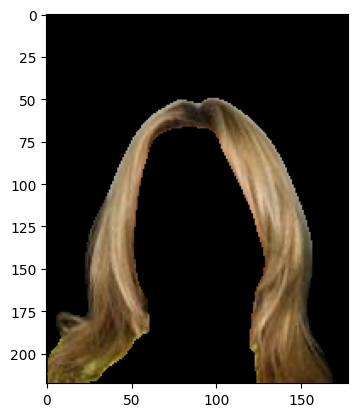

Average Color (RGB): (131, 105, 69)
Dominant Color (RGB): (179, 151, 113)
Color Comparison Results:
black - Avg Distance: 52.32140789622179, Dominant Distance: 68.58368247182513
brown - Avg Distance: 20.43549523599309, Dominant Distance: 36.38821493590559
dark_brown - Avg Distance: 34.42636935062836, Dominant Distance: 50.87371175467527
blonde - Avg Distance: 24.25744175927321, Dominant Distance: 10.904834131034946
dark_blonde - Avg Distance: 11.727137243850002, Dominant Distance: 18.116575219997802
red - Avg Distance: 37.510187486663106, Dominant Distance: 50.87218202757914
grey - Avg Distance: 27.319418699978108, Dominant Distance: 38.39940338831467
The closest color classification is: dark_blonde
Processing image: 000094.jpg


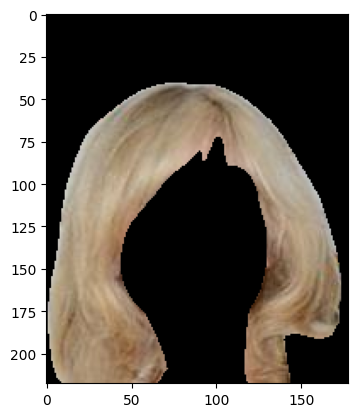

Average Color (RGB): (166, 144, 118)
Dominant Color (RGB): (165, 138, 110)
Color Comparison Results:
black - Avg Distance: 63.523701157357436, Dominant Distance: 62.46348992452281
brown - Avg Distance: 32.097063019048385, Dominant Distance: 30.309649775696123
dark_brown - Avg Distance: 46.18022580478031, Dominant Distance: 44.765303103726964
blonde - Avg Distance: 18.5358394749351, Dominant Distance: 17.708515846365348
dark_blonde - Avg Distance: 21.508348969467583, Dominant Distance: 18.863382994247246
red - Avg Distance: 48.958454906746404, Dominant Distance: 46.26057356953337
grey - Avg Distance: 31.811803831897997, Dominant Distance: 31.711789864457607
The closest color classification is: blonde
Processing image: 000024.jpg


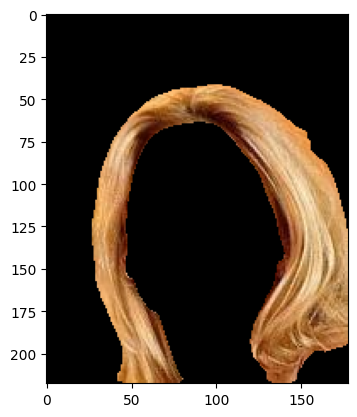

Average Color (RGB): (189, 133, 81)
Dominant Color (RGB): (225, 173, 117)
Color Comparison Results:
black - Avg Distance: 71.95271666560278, Dominant Distance: 83.4709560015557
brown - Avg Distance: 38.67507339986923, Dominant Distance: 50.172378491895856
dark_brown - Avg Distance: 53.470596199506225, Dominant Distance: 65.17112121935139
blonde - Avg Distance: 14.392275931176139, Dominant Distance: 10.236597314010329
dark_blonde - Avg Distance: 14.592707557404948, Dominant Distance: 25.336244343385804
red - Avg Distance: 44.571374414454404, Dominant Distance: 58.18944124222316
grey - Avg Distance: 47.175508991487334, Dominant Distance: 55.08252467112954
The closest color classification is: blonde
Processing image: 007.jpg


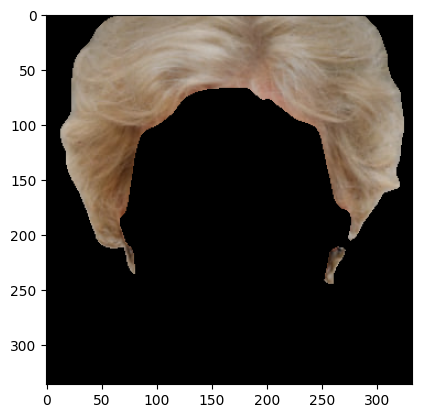

Average Color (RGB): (155, 133, 111)
Dominant Color (RGB): (154, 131, 108)
Color Comparison Results:
black - Avg Distance: 59.104705091982744, Dominant Distance: 58.65169201551832
brown - Avg Distance: 27.73379975278882, Dominant Distance: 27.064964242129356
dark_brown - Avg Distance: 41.73949603811065, Dominant Distance: 41.1815366585089
blonde - Avg Distance: 22.112241719626173, Dominant Distance: 21.86797871125406
dark_blonde - Avg Distance: 21.44018955966686, Dominant Distance: 20.51576736935304
red - Avg Distance: 45.52902397480002, Dominant Distance: 44.73236366569801
grey - Avg Distance: 27.471723786745176, Dominant Distance: 27.374057363277466
The closest color classification is: dark_blonde
Processing image: 0000012.jpg


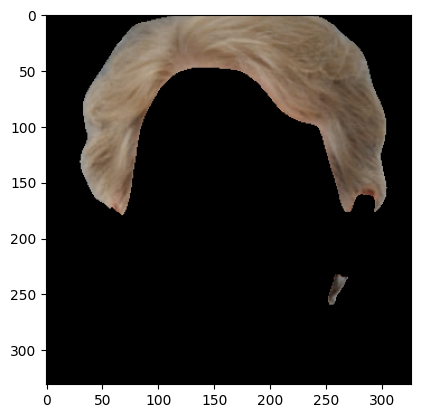

Average Color (RGB): (137, 117, 97)
Dominant Color (RGB): (136, 114, 94)
Color Comparison Results:
black - Avg Distance: 52.655155585254555, Dominant Distance: 51.897735982935565
brown - Avg Distance: 21.530935393605183, Dominant Distance: 20.379130799990804
dark_brown - Avg Distance: 35.282976604824285, Dominant Distance: 34.34886897721702
blonde - Avg Distance: 26.731541624975588, Dominant Distance: 27.142708340969126
dark_blonde - Avg Distance: 21.310984142783827, Dominant Distance: 20.90986368259719
red - Avg Distance: 41.34090151121988, Dominant Distance: 39.98040633907265
grey - Avg Distance: 21.78402068718343, Dominant Distance: 21.523135297535305
The closest color classification is: brown
Processing image: 000018.jpg


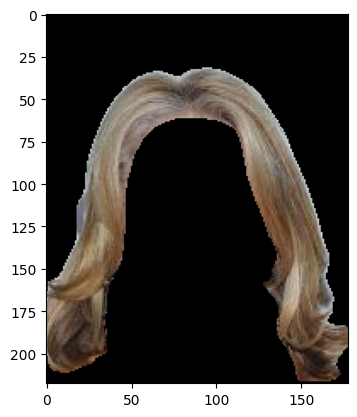

Average Color (RGB): (125, 107, 91)
Dominant Color (RGB): (129, 109, 90)
Color Comparison Results:
black - Avg Distance: 48.11927115186471, Dominant Distance: 49.5553029626671
brown - Avg Distance: 17.67261677215743, Dominant Distance: 18.418377682081726
dark_brown - Avg Distance: 30.900192043776972, Dominant Distance: 32.104515889660966
blonde - Avg Distance: 31.21413851127889, Dominant Distance: 29.178018024801208
dark_blonde - Avg Distance: 23.875082359500333, Dominant Distance: 21.808798545989752
red - Avg Distance: 39.257413819249436, Dominant Distance: 39.160116529602085
grey - Avg Distance: 17.29705578236034, Dominant Distance: 19.365901092016905
The closest color classification is: brown
Processing folder: Brown
Processing image: 000163.jpg


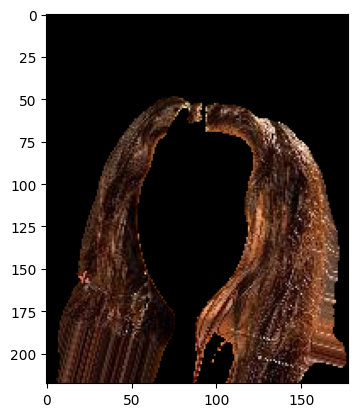

Average Color (RGB): (82, 47, 32)
Dominant Color (RGB): (47, 19, 10)
Color Comparison Results:
black - Avg Distance: 31.943840280281638, Dominant Distance: 19.727388756536786
brown - Avg Distance: 8.329150494648536, Dominant Distance: 20.457622149367637
dark_brown - Avg Distance: 13.90602933221113, Dominant Distance: 9.770376074387435
blonde - Avg Distance: 49.18555718960352, Dominant Distance: 63.61856371161439
dark_blonde - Avg Distance: 33.70100186389363, Dominant Distance: 47.72045968354795
red - Avg Distance: 20.67989143519051, Dominant Distance: 26.70423768587217
grey - Avg Distance: 24.330412146197496, Dominant Distance: 30.087940731623338
The closest color classification is: dark_brown
Processing image: 000116.jpg


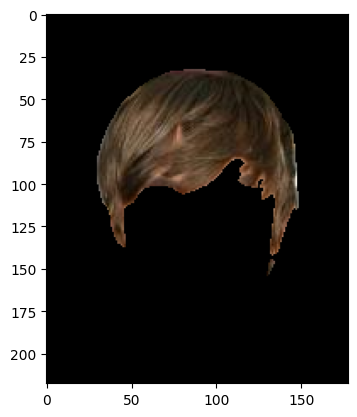

Average Color (RGB): (79, 59, 41)
Dominant Color (RGB): (50, 36, 22)
Color Comparison Results:
black - Avg Distance: 30.91740717975299, Dominant Distance: 20.026157036092265
brown - Avg Distance: 5.636370575117952, Dominant Distance: 15.57475862404781
dark_brown - Avg Distance: 12.717796720054906, Dominant Distance: 4.718663101323683
blonde - Avg Distance: 46.01163025897146, Dominant Distance: 57.21132409155949
dark_blonde - Avg Distance: 31.18102470532852, Dominant Distance: 41.60567868095154
red - Avg Distance: 29.27329820252196, Dominant Distance: 32.12557254247204
grey - Avg Distance: 17.618357930723295, Dominant Distance: 22.839378066123228
The closest color classification is: dark_brown
Processing image: 000083.jpg


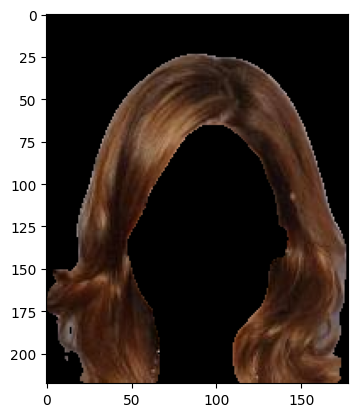

Average Color (RGB): (82, 51, 35)
Dominant Color (RGB): (54, 27, 16)
Color Comparison Results:
black - Avg Distance: 31.630556832942347, Dominant Distance: 22.106923575463455
brown - Avg Distance: 6.338044970115166, Dominant Distance: 16.691453947379447
dark_brown - Avg Distance: 13.176108138800926, Dominant Distance: 8.139349969461414
blonde - Avg Distance: 47.90988463222941, Dominant Distance: 59.40091745942067
dark_blonde - Avg Distance: 32.55988642602925, Dominant Distance: 43.420308033395806
red - Avg Distance: 23.04167051654834, Dominant Distance: 25.544956399155915
grey - Avg Distance: 22.210698810146233, Dominant Distance: 27.59867587555717
The closest color classification is: dark_brown
Processing image: 0076778.jpg


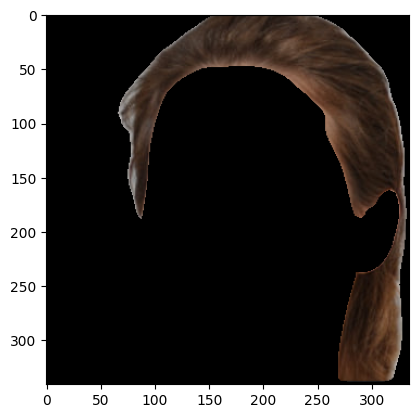

Average Color (RGB): (74, 53, 41)
Dominant Color (RGB): (55, 36, 26)
Color Comparison Results:
black - Avg Distance: 27.74141024499021, Dominant Distance: 20.661261785599347
brown - Avg Distance: 6.486169365086931, Dominant Distance: 14.121543231440725
dark_brown - Avg Distance: 9.107755922421717, Dominant Distance: 2.869239458825109
blonde - Avg Distance: 49.68657409858874, Dominant Distance: 57.24495784461443
dark_blonde - Avg Distance: 35.22857230304064, Dominant Distance: 41.9541448457365
red - Avg Distance: 28.50122205145158, Dominant Distance: 29.56485027186213
grey - Avg Distance: 16.99906951149898, Dominant Distance: 22.231441498593558
The closest color classification is: dark_brown
Processing image: 00004454.jpg


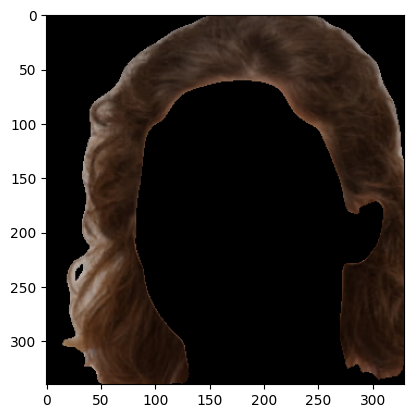

Average Color (RGB): (65, 44, 32)
Dominant Color (RGB): (46, 27, 17)
Color Comparison Results:
black - Avg Distance: 24.59171512947694, Dominant Distance: 17.80264385242651
brown - Avg Distance: 10.062836535511721, Dominant Distance: 18.17567557131927
dark_brown - Avg Distance: 6.007335309495013, Dominant Distance: 5.042791529868286
blonde - Avg Distance: 53.16160317119237, Dominant Distance: 61.11213160900353
dark_blonde - Avg Distance: 38.06029982586436, Dominant Distance: 45.39128513283182
red - Avg Distance: 28.137235182688737, Dominant Distance: 30.33575277182887
grey - Avg Distance: 20.060971384539787, Dominant Distance: 26.030146779606387
The closest color classification is: dark_brown
Processing image: 003456.jpg


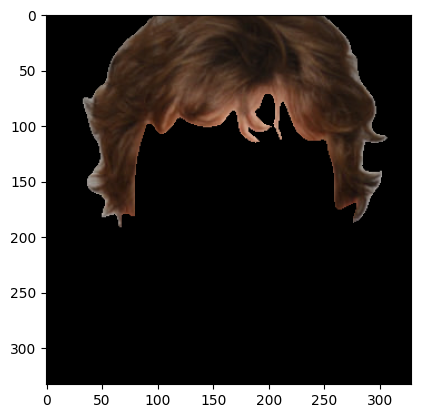

Average Color (RGB): (77, 52, 38)
Dominant Color (RGB): (54, 34, 23)
Color Comparison Results:
black - Avg Distance: 29.182484994004128, Dominant Distance: 20.734012209903025
brown - Avg Distance: 5.750067907550458, Dominant Distance: 14.690091683464022
dark_brown - Avg Distance: 10.47370931609466, Dominant Distance: 3.9711994151296723
blonde - Avg Distance: 48.87983003197227, Dominant Distance: 57.619433373592564
dark_blonde - Avg Distance: 33.96747930110042, Dominant Distance: 42.06913582889637
red - Avg Distance: 26.25097562841559, Dominant Distance: 28.99332967957801
grey - Avg Distance: 19.194314778032773, Dominant Distance: 23.521053335178756
The closest color classification is: dark_brown
Processing image: 0002345.jpg


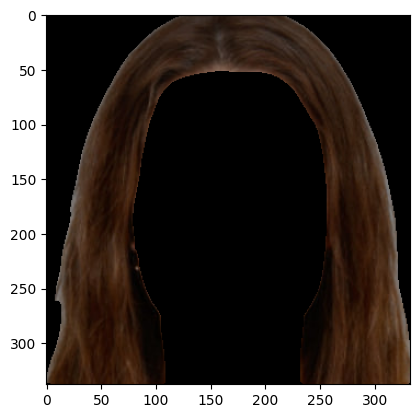

Average Color (RGB): (56, 34, 21)
Dominant Color (RGB): (65, 40, 24)
Color Comparison Results:
black - Avg Distance: 22.22896737418841, Dominant Distance: 26.102008455689933
brown - Avg Distance: 14.25626742374204, Dominant Distance: 11.325048932705142
dark_brown - Avg Distance: 5.881474385913181, Dominant Distance: 8.760895412607862
blonde - Avg Distance: 56.77147091378791, Dominant Distance: 53.13241598200495
dark_blonde - Avg Distance: 40.93827068812247, Dominant Distance: 37.19793676671133
red - Avg Distance: 27.67797040320239, Dominant Distance: 25.68666918930834
grey - Avg Distance: 24.492975576418452, Dominant Distance: 23.88776161159572
The closest color classification is: dark_brown
Processing image: 000236.jpg


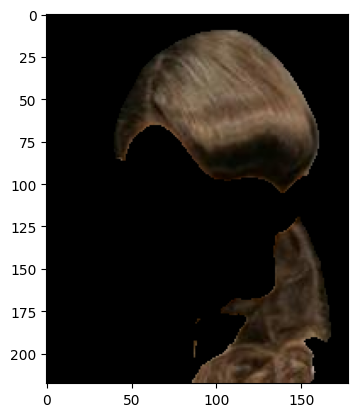

Average Color (RGB): (78, 61, 44)
Dominant Color (RGB): (120, 98, 75)
Color Comparison Results:
black - Avg Distance: 30.581483877202178, Dominant Distance: 46.4482291284519
brown - Avg Distance: 6.269250065099427, Dominant Distance: 14.631130886891189
dark_brown - Avg Distance: 12.681291083407821, Dominant Distance: 28.613922153742045
blonde - Avg Distance: 46.03550024971307, Dominant Distance: 30.67460117348721
dark_blonde - Avg Distance: 31.627202314084318, Dominant Distance: 19.97751168325458
red - Avg Distance: 30.942772957691627, Dominant Distance: 35.774867295425075
grey - Avg Distance: 15.903466708784693, Dominant Distance: 19.320165002675388
The closest color classification is: brown
Processing image: 000107.jpg


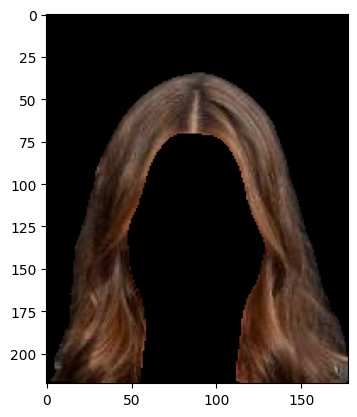

Average Color (RGB): (85, 58, 43)
Dominant Color (RGB): (90, 61, 46)
Color Comparison Results:
black - Avg Distance: 32.096797314108265, Dominant Distance: 33.779762844478846
brown - Avg Distance: 3.080511631558607, Dominant Distance: 1.9857502113238163
dark_brown - Avg Distance: 13.352179845789951, Dominant Distance: 15.005799196106434
blonde - Avg Distance: 46.05360327903725, Dominant Distance: 44.66333663697531
dark_blonde - Avg Distance: 31.42535025181809, Dominant Distance: 30.2662005358795
red - Avg Distance: 25.822156186183726, Dominant Distance: 25.29408745896918
grey - Avg Distance: 18.68882395625222, Dominant Distance: 18.783383408012234
The closest color classification is: brown
Processing image: 000222.jpg


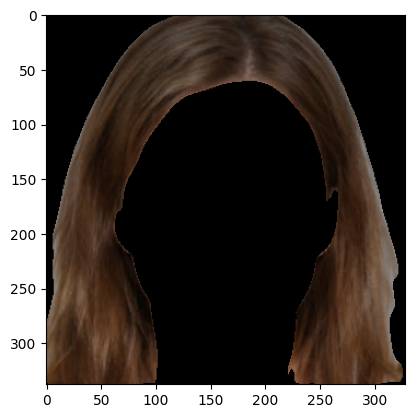

Average Color (RGB): (71, 49, 35)
Dominant Color (RGB): (77, 53, 37)
Color Comparison Results:
black - Avg Distance: 27.123299613018634, Dominant Distance: 29.64337071719966
brown - Avg Distance: 7.734479133406553, Dominant Distance: 5.8683762429703705
dark_brown - Avg Distance: 8.547084091756425, Dominant Distance: 11.083956240374588
blonde - Avg Distance: 50.51994944088164, Dominant Distance: 48.147291143817554
dark_blonde - Avg Distance: 35.461022895870315, Dominant Distance: 33.0422183121675
red - Avg Distance: 27.621734550736527, Dominant Distance: 26.7620037718197
grey - Avg Distance: 19.283191998656523, Dominant Distance: 19.418645946940206
The closest color classification is: brown
Processing folder: Grey
Processing image: 000078.jpg


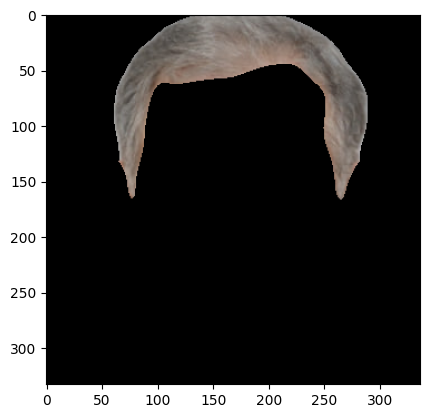

Average Color (RGB): (130, 119, 111)
Dominant Color (RGB): (129, 118, 110)
Color Comparison Results:
black - Avg Distance: 51.20953013916446, Dominant Distance: 50.81835147187584
brown - Avg Distance: 23.279633484335545, Dominant Distance: 22.91975498350105
dark_brown - Avg Distance: 35.120103130199595, Dominant Distance: 34.725836728129366
blonde - Avg Distance: 33.07129788633953, Dominant Distance: 33.2739573135283
dark_blonde - Avg Distance: 29.41288216796834, Dominant Distance: 29.394065733697374
red - Avg Distance: 44.7040118274216, Dominant Distance: 44.45048499494891
grey - Avg Distance: 17.59777533096818, Dominant Distance: 17.23511180156673
The closest color classification is: grey
Processing image: 000213.jpg


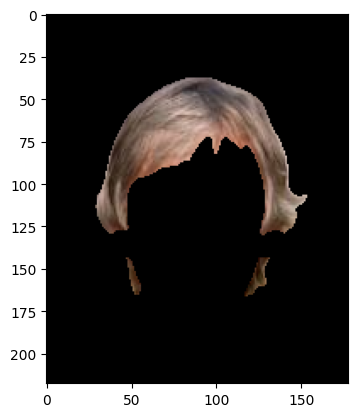

Average Color (RGB): (133, 106, 93)
Dominant Color (RGB): (134, 107, 95)
Color Comparison Results:
black - Avg Distance: 49.21607767583191, Dominant Distance: 49.5120176989748
brown - Avg Distance: 17.35553996288329, Dominant Distance: 17.819190327044026
dark_brown - Avg Distance: 31.48241144388615, Dominant Distance: 31.847120182659676
blonde - Avg Distance: 31.285515120920028, Dominant Distance: 31.44727092016259
dark_blonde - Avg Distance: 24.234786489106263, Dominant Distance: 24.78127702935211
red - Avg Distance: 36.5516723072154, Dominant Distance: 36.89210475393376
grey - Avg Distance: 19.095214454363187, Dominant Distance: 19.09878625818152
The closest color classification is: brown
Processing image: 00099876.jpg


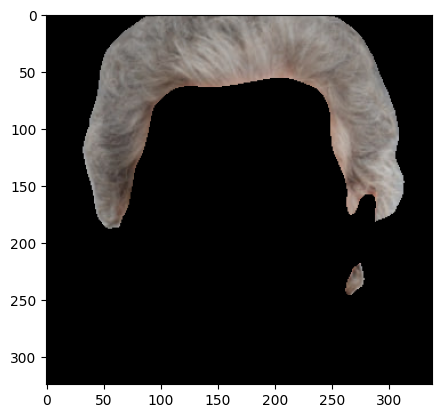

Average Color (RGB): (138, 128, 122)
Dominant Color (RGB): (134, 125, 119)
Color Comparison Results:
black - Avg Distance: 54.55058256240842, Dominant Distance: 53.26424050970753
brown - Avg Distance: 26.862928506554052, Dominant Distance: 25.87126273347639
dark_brown - Avg Distance: 38.68695012370755, Dominant Distance: 37.482248453340496
blonde - Avg Distance: 32.54350323376155, Dominant Distance: 33.23270921336053
dark_blonde - Avg Distance: 31.019942394097114, Dominant Distance: 31.02193545712906
red - Avg Distance: 47.449523637356464, Dominant Distance: 46.91986344052109
grey - Avg Distance: 20.541335090670916, Dominant Distance: 19.245800571236956
The closest color classification is: grey
Processing image: 000084.jpg


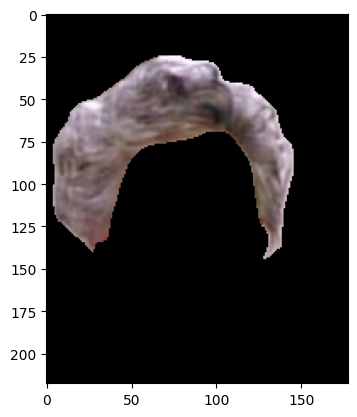

Average Color (RGB): (135, 117, 120)
Dominant Color (RGB): (101, 82, 79)
Color Comparison Results:
black - Avg Distance: 51.51461249038124, Dominant Distance: 37.707214109819944
brown - Avg Distance: 24.36018989165056, Dominant Distance: 10.969460441830892
dark_brown - Avg Distance: 35.707591961786946, Dominant Distance: 21.00125921047228
blonde - Avg Distance: 37.442927966351235, Dominant Distance: 43.15525714199426
dark_blonde - Avg Distance: 34.367026212692295, Dominant Distance: 33.30122186104489
red - Avg Distance: 43.58209526722273, Dominant Distance: 34.28961317978513
grey - Avg Distance: 18.155760205170946, Dominant Distance: 9.020574209332432
The closest color classification is: grey
Processing image: 000221.jpg


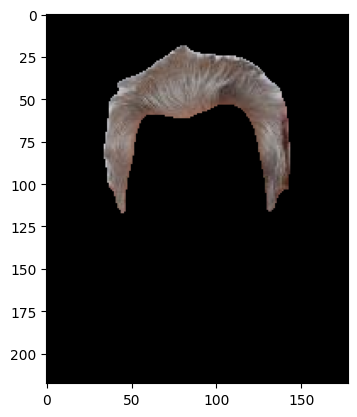

Average Color (RGB): (128, 112, 106)
Dominant Color (RGB): (129, 112, 106)
Color Comparison Results:
black - Avg Distance: 49.13364061566488, Dominant Distance: 49.291475121586885
brown - Avg Distance: 20.646963292144736, Dominant Distance: 20.586130869239952
dark_brown - Avg Distance: 32.71721534391345, Dominant Distance: 32.79204230765426
blonde - Avg Distance: 34.5446430738918, Dominant Distance: 34.377935470108376
dark_blonde - Avg Distance: 29.619237433669912, Dominant Distance: 29.463090951366677
red - Avg Distance: 41.70452122705481, Dominant Distance: 41.427685183985304
grey - Avg Distance: 16.02453920584367, Dominant Distance: 16.297847066557768
The closest color classification is: grey
Processing image: 0002456.jpg


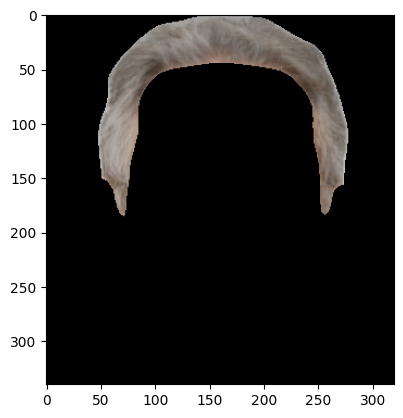

Average Color (RGB): (135, 125, 116)
Dominant Color (RGB): (136, 125, 116)
Color Comparison Results:
black - Avg Distance: 53.450755540575514, Dominant Distance: 53.57527047228343
brown - Avg Distance: 25.412573515540547, Dominant Distance: 25.33577496924131
dark_brown - Avg Distance: 37.402208933803315, Dominant Distance: 37.444477180221945
blonde - Avg Distance: 31.66832589426814, Dominant Distance: 31.477079108426224
dark_blonde - Avg Distance: 29.27763500857762, Dominant Distance: 29.106362011966254
red - Avg Distance: 46.45014712916753, Dominant Distance: 46.19207893693955
grey - Avg Distance: 19.73371403843667, Dominant Distance: 19.911872734936317
The closest color classification is: grey
Processing image: g3.jpg


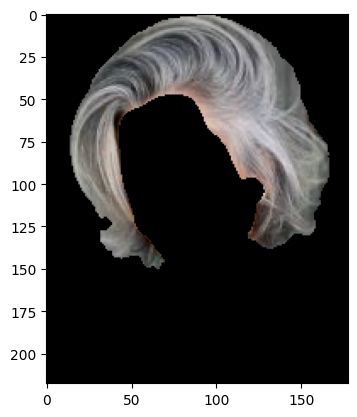

Average Color (RGB): (130, 126, 124)
Dominant Color (RGB): (124, 121, 119)
Color Comparison Results:
black - Avg Distance: 53.120405646128, Dominant Distance: 51.054396685956014
brown - Avg Distance: 27.35969068645968, Dominant Distance: 25.82843394237621
dark_brown - Avg Distance: 38.040937481993176, Dominant Distance: 36.1116747155475
blonde - Avg Distance: 35.86403435644181, Dominant Distance: 36.924838293437226
dark_blonde - Avg Distance: 34.003849813941684, Dominant Distance: 34.04739246015507
red - Avg Distance: 48.81677865456138, Dominant Distance: 47.883315482639546
grey - Avg Distance: 18.73401998200374, Dominant Distance: 16.657389072190615
The closest color classification is: grey
Processing image: g4.jpg


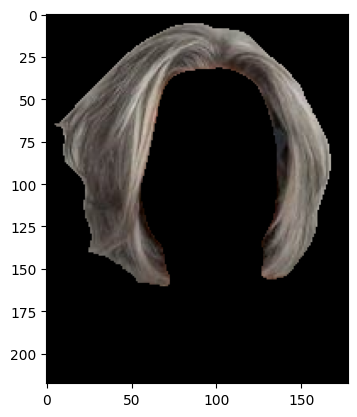

Average Color (RGB): (109, 101, 94)
Dominant Color (RGB): (111, 103, 96)
Color Comparison Results:
black - Avg Distance: 43.64902197622918, Dominant Distance: 44.45417848692222
brown - Avg Distance: 17.66417680636269, Dominant Distance: 18.30314951729282
dark_brown - Avg Distance: 27.90911522681438, Dominant Distance: 28.71177408906693
blonde - Avg Distance: 38.23223869314525, Dominant Distance: 37.72071501428741
dark_blonde - Avg Distance: 31.033954534647517, Dominant Distance: 30.889494773441065
red - Avg Distance: 41.49333466760312, Dominant Distance: 41.914363672564086
grey - Avg Distance: 10.383940348424515, Dominant Distance: 11.076327587466501
The closest color classification is: grey
Processing image: g1.jpg


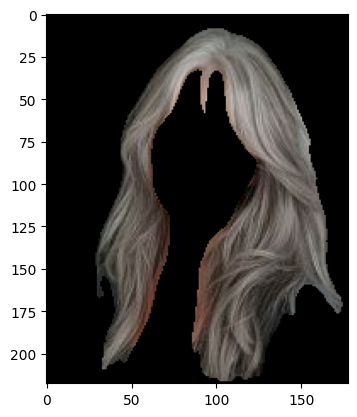

Average Color (RGB): (100, 93, 87)
Dominant Color (RGB): (103, 95, 89)
Color Comparison Results:
black - Avg Distance: 40.24015851996607, Dominant Distance: 41.186824104609684
brown - Avg Distance: 15.709439894242882, Dominant Distance: 16.037241142097717
dark_brown - Avg Distance: 24.737947999575475, Dominant Distance: 25.545117253765632
blonde - Avg Distance: 40.97508235526076, Dominant Distance: 40.22497599787798
dark_blonde - Avg Distance: 32.55002831549086, Dominant Distance: 32.11068516137095
red - Avg Distance: 40.355881915617736, Dominant Distance: 40.37781892577218
grey - Avg Distance: 7.268881631767199, Dominant Distance: 8.154488527886883
The closest color classification is: grey
Processing image: 000276.jpg


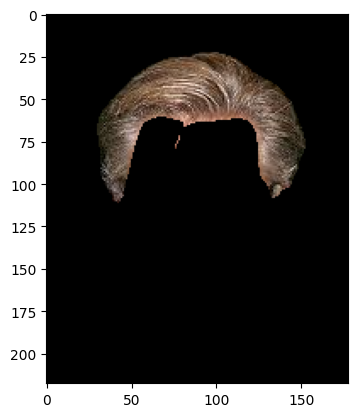

Average Color (RGB): (112, 89, 73)
Dominant Color (RGB): (119, 94, 77)
Color Comparison Results:
black - Avg Distance: 42.29465548535385, Dominant Distance: 44.7377255929009
brown - Avg Distance: 10.411056784918072, Dominant Distance: 12.42495672879656
dark_brown - Avg Distance: 24.35685985345276, Dominant Distance: 26.73290522282861
blonde - Avg Distance: 35.62648766585452, Dominant Distance: 33.43283502888834
dark_blonde - Avg Distance: 24.644702554999917, Dominant Distance: 23.125882045777935
red - Avg Distance: 33.2204639881672, Dominant Distance: 33.75211236065668
grey - Avg Distance: 15.499583486661157, Dominant Distance: 17.26938099466208
The closest color classification is: brown
Processing folder: Red
Processing image: 000045.jpg


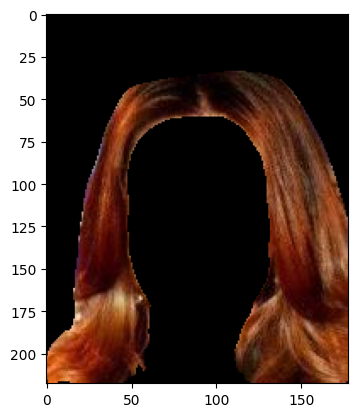

Average Color (RGB): (104, 46, 24)
Dominant Color (RGB): (60, 15, 7)
Color Comparison Results:
black - Avg Distance: 44.45235261421474, Dominant Distance: 28.500939245117905
brown - Avg Distance: 19.504126544393724, Dominant Distance: 21.714975947978527
dark_brown - Avg Distance: 27.753215679268916, Dominant Distance: 17.297311590052516
blonde - Avg Distance: 46.92100391569832, Dominant Distance: 62.499806497510676
dark_blonde - Avg Distance: 31.4327851445621, Dominant Distance: 46.5675967528907
red - Avg Distance: 12.185677268441605, Dominant Distance: 18.19514154814025
grey - Avg Distance: 36.44051223566952, Dominant Distance: 34.83938280974959
The closest color classification is: red
Processing image: 000088.jpg


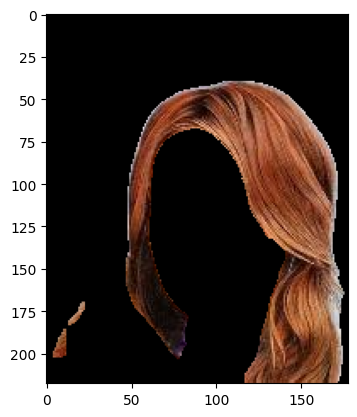

Average Color (RGB): (131, 76, 53)
Dominant Color (RGB): (143, 76, 47)
Color Comparison Results:
black - Avg Distance: 49.54456419399397, Dominant Distance: 55.832297902774165
brown - Avg Distance: 17.23462585222468, Dominant Distance: 24.73527878143164
dark_brown - Avg Distance: 30.989497308418283, Dominant Distance: 37.665121888399916
blonde - Avg Distance: 35.82780530376752, Dominant Distance: 35.76393913619435
dark_blonde - Avg Distance: 22.61980656018896, Dominant Distance: 23.280546724594785
red - Avg Distance: 20.847670112860307, Dominant Distance: 21.27828099511646
grey - Avg Distance: 31.67154282297825, Dominant Distance: 39.39568545064767
The closest color classification is: brown
Processing image: 000170.jpg


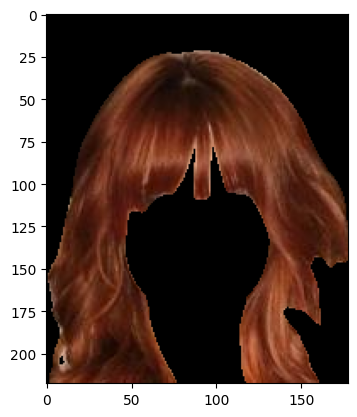

Average Color (RGB): (101, 47, 28)
Dominant Color (RGB): (71, 27, 13)
Color Comparison Results:
black - Avg Distance: 41.816420811535025, Dominant Distance: 32.024912341130424
brown - Avg Distance: 16.504642408142313, Dominant Distance: 17.807056136481776
dark_brown - Avg Distance: 24.78558544010429, Dominant Distance: 17.673144297209657
blonde - Avg Distance: 47.00220677100437, Dominant Distance: 56.3740171593188
dark_blonde - Avg Distance: 31.591215697724227, Dominant Distance: 40.14772565076308
red - Avg Distance: 12.657879120285063, Dominant Distance: 15.980326611846964
grey - Avg Distance: 33.41086746673179, Dominant Distance: 33.03778820055972
The closest color classification is: red
Processing image: 000257.jpg


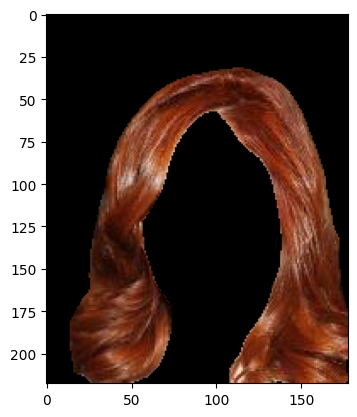

Average Color (RGB): (117, 54, 33)
Dominant Color (RGB): (81, 27, 12)
Color Comparison Results:
black - Avg Distance: 47.79386805379249, Dominant Distance: 37.66837861113583
brown - Avg Distance: 20.370199071412458, Dominant Distance: 20.560294823929794
dark_brown - Avg Distance: 30.494214480372882, Dominant Distance: 23.209206585914814
blonde - Avg Distance: 44.13951332987692, Dominant Distance: 55.24347381916413
dark_blonde - Avg Distance: 29.68351431523752, Dominant Distance: 39.217024440029235
red - Avg Distance: 12.81139408577955, Dominant Distance: 11.294637300214674
grey - Avg Distance: 36.80749266383919, Dominant Distance: 36.777345398832054
The closest color classification is: red
Processing image: 000002.jpg


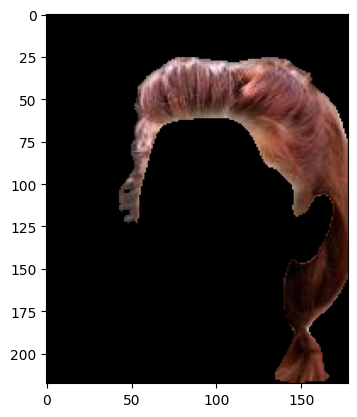

Average Color (RGB): (113, 69, 62)
Dominant Color (RGB): (120, 71, 62)
Color Comparison Results:
black - Avg Distance: 40.563242804854454, Dominant Distance: 43.30090885047421
brown - Avg Distance: 8.887623526111744, Dominant Distance: 11.303059214916994
dark_brown - Avg Distance: 22.14884171021719, Dominant Distance: 24.833655447675124
blonde - Avg Distance: 42.71305963521528, Dominant Distance: 41.12936672379124
dark_blonde - Avg Distance: 30.62498180190218, Dominant Distance: 29.143981110217805
red - Avg Distance: 21.64576489127107, Dominant Distance: 20.394708209074818
grey - Avg Distance: 21.777269213082732, Dominant Distance: 24.549320339345186
The closest color classification is: brown
Processing image: 000150.jpg


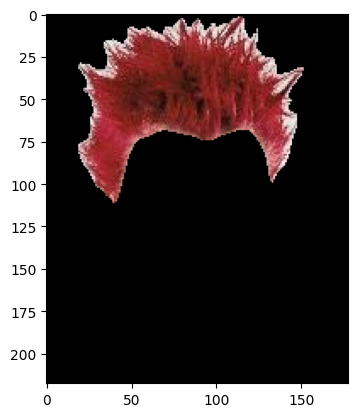

Average Color (RGB): (149, 68, 67)
Dominant Color (RGB): (125, 36, 34)
Color Comparison Results:
black - Avg Distance: 54.78473597768909, Dominant Distance: 53.16292778676965
brown - Avg Distance: 25.862970287872834, Dominant Distance: 29.790410285850587
dark_brown - Avg Distance: 37.418804375516885, Dominant Distance: 37.63119156113252
blonde - Avg Distance: 44.7218031344858, Dominant Distance: 53.19349678347324
dark_blonde - Avg Distance: 35.45782928156344, Dominant Distance: 40.84728147843607
red - Avg Distance: 16.96342712492304, Dominant Distance: 7.499889248290357
grey - Avg Distance: 38.32870759098154, Dominant Distance: 45.08586019550835
The closest color classification is: red
Processing image: 000174.jpg


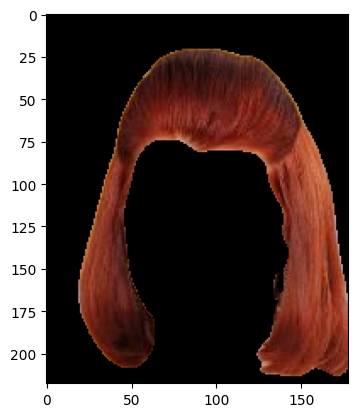

Average Color (RGB): (120, 48, 33)
Dominant Color (RGB): (130, 48, 33)
Color Comparison Results:
black - Avg Distance: 49.54852521668485, Dominant Distance: 54.35406159305695
brown - Avg Distance: 23.59868180311966, Dominant Distance: 28.347684245227953
dark_brown - Avg Distance: 32.833761331013235, Dominant Distance: 37.82934601396547
blonde - Avg Distance: 47.27744568890112, Dominant Distance: 47.819550371795756
dark_blonde - Avg Distance: 33.64062507716933, Dominant Distance: 35.11972822046073
red - Avg Distance: 9.401571742957096, Dominant Distance: 11.411658421445168
grey - Avg Distance: 39.72281549962498, Dominant Distance: 44.20650340375849
The closest color classification is: red
Processing image: 000128.jpg


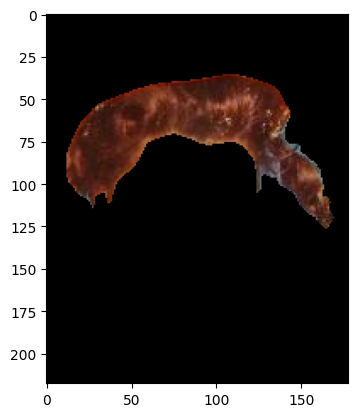

Average Color (RGB): (96, 46, 32)
Dominant Color (RGB): (75, 30, 19)
Color Comparison Results:
black - Avg Distance: 38.36248905484738, Dominant Distance: 32.34592616688012
brown - Avg Distance: 13.52953107855762, Dominant Distance: 16.486896779547685
dark_brown - Avg Distance: 21.130280091863085, Dominant Distance: 17.301268461201513
blonde - Avg Distance: 48.430673825538776, Dominant Distance: 55.4649502536694
dark_blonde - Avg Distance: 33.321689171615816, Dominant Distance: 39.601055514688014
red - Avg Distance: 13.481163299779885, Dominant Distance: 15.211894863577264
grey - Avg Distance: 30.141459554845877, Dominant Distance: 31.739172399236452
The closest color classification is: red
Processing image: 000155.jpg


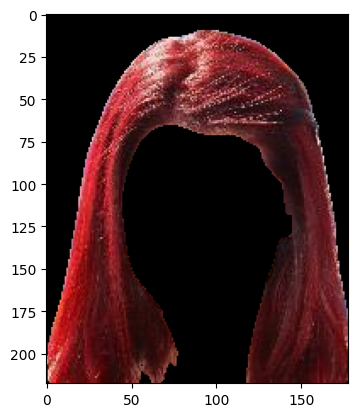

Average Color (RGB): (108, 38, 41)
Dominant Color (RGB): (75, 20, 23)
Color Comparison Results:
black - Avg Distance: 43.29186673066706, Dominant Distance: 33.02968779517934
brown - Avg Distance: 21.536678221493684, Dominant Distance: 21.215966640204
dark_brown - Avg Distance: 27.804447459324813, Dominant Distance: 20.325951338988126
blonde - Avg Distance: 53.9078420587594, Dominant Distance: 60.81619300733812
dark_blonde - Avg Distance: 40.99246479883783, Dominant Distance: 46.0107060182062
red - Avg Distance: 7.335985358732438, Dominant Distance: 13.515385359912965
grey - Avg Distance: 35.66402833432912, Dominant Distance: 34.49492689631553
The closest color classification is: red
Processing image: 000189.jpg


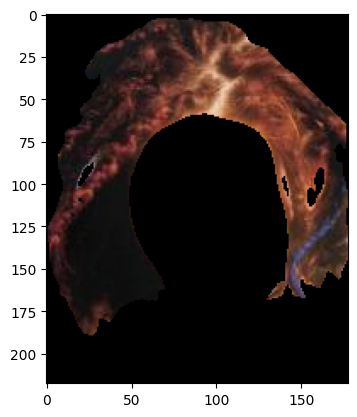

Average Color (RGB): (75, 45, 37)
Dominant Color (RGB): (33, 22, 21)
Color Comparison Results:
black - Avg Distance: 27.653295217133262, Dominant Distance: 10.516583687458033
brown - Avg Distance: 8.469606150199937, Dominant Distance: 24.023044059615614
dark_brown - Avg Distance: 9.337930306352773, Dominant Distance: 8.851015288390771
blonde - Avg Distance: 52.40916576145325, Dominant Distance: 67.33848780651971
dark_blonde - Avg Distance: 37.76362767830023, Dominant Distance: 52.53536055338793
red - Avg Distance: 23.76492160093077, Dominant Distance: 36.911836771306724
grey - Avg Distance: 20.928267693042017, Dominant Distance: 26.579689040571125
The closest color classification is: dark_brown
Processing folder: Dark Brown
Processing image: 000180.jpg


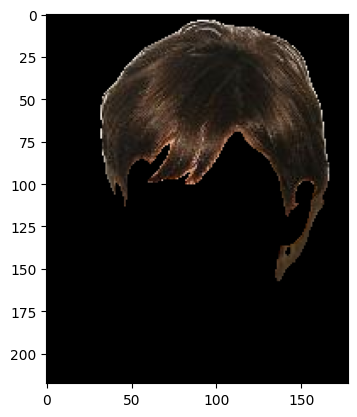

Average Color (RGB): (62, 49, 38)
Dominant Color (RGB): (41, 31, 23)
Color Comparison Results:
black - Avg Distance: 23.676670329691202, Dominant Distance: 15.026434931667653
brown - Avg Distance: 11.148507157447833, Dominant Distance: 19.325275930076323
dark_brown - Avg Distance: 6.269127536614079, Dominant Distance: 4.462867054331629
blonde - Avg Distance: 52.95479053142179, Dominant Distance: 61.644027335500944
dark_blonde - Avg Distance: 38.57871273290496, Dominant Distance: 46.58026394950999
red - Avg Distance: 32.57809281957218, Dominant Distance: 35.29585758688812
grey - Avg Distance: 16.45007827871358, Dominant Distance: 23.199672605732285
The closest color classification is: dark_brown
Processing image: 000078.jpg


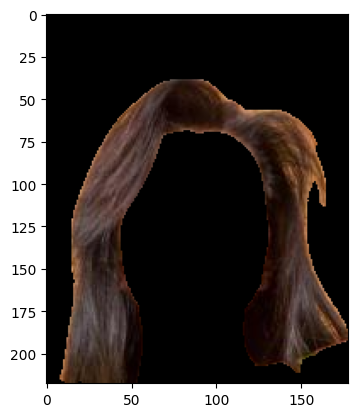

Average Color (RGB): (74, 49, 39)
Dominant Color (RGB): (80, 56, 47)
Color Comparison Results:
black - Avg Distance: 27.33462419309034, Dominant Distance: 29.298584445249865
brown - Avg Distance: 7.123625665988403, Dominant Distance: 4.984004238625102
dark_brown - Avg Distance: 8.553191145738358, Dominant Distance: 10.696075939243531
blonde - Avg Distance: 51.100787457436205, Dominant Distance: 48.94554587587346
dark_blonde - Avg Distance: 36.53470410034781, Dominant Distance: 35.10962705840028
red - Avg Distance: 26.361932489503864, Dominant Distance: 27.524454335207004
grey - Avg Distance: 18.697572143995053, Dominant Distance: 15.978212219919982
The closest color classification is: brown
Processing image: 000259.jpg


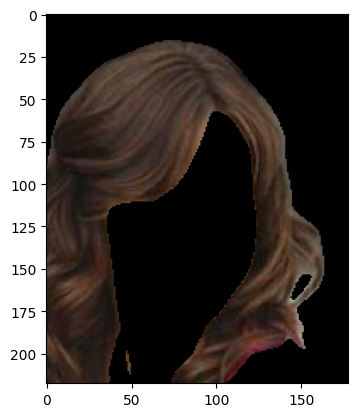

Average Color (RGB): (66, 48, 39)
Dominant Color (RGB): (45, 31, 24)
Color Comparison Results:
black - Avg Distance: 24.369521715995305, Dominant Distance: 16.2010398690049
brown - Avg Distance: 9.763440264283812, Dominant Distance: 18.079688687937367
dark_brown - Avg Distance: 5.891510773078596, Dominant Distance: 2.788901968509176
blonde - Avg Distance: 52.964734243527175, Dominant Distance: 61.08911713611699
dark_blonde - Avg Distance: 38.62187602287553, Dominant Distance: 46.008129561144735
red - Avg Distance: 30.10131834843409, Dominant Distance: 33.11509145012489
grey - Avg Distance: 17.004418924686576, Dominant Distance: 23.156463609977465
The closest color classification is: dark_brown
Processing image: 000043.jpg


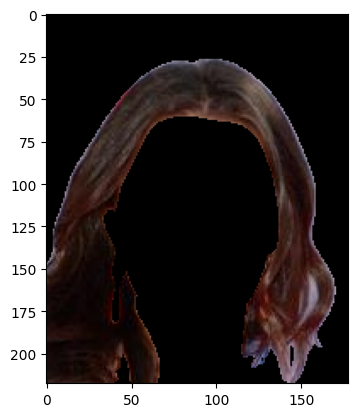

Average Color (RGB): (56, 35, 33)
Dominant Color (RGB): (30, 12, 9)
Color Comparison Results:
black - Avg Distance: 19.722681961656622, Dominant Distance: 9.951475757033192
brown - Avg Distance: 15.471787783101345, Dominant Distance: 26.47206055537468
dark_brown - Avg Distance: 3.990693064837669, Dominant Distance: 11.515568277607064
blonde - Avg Distance: 59.56497584846618, Dominant Distance: 70.04035654966255
dark_blonde - Avg Distance: 45.1552888698121, Dominant Distance: 54.71431291801215
red - Avg Distance: 29.707310956164132, Dominant Distance: 36.22641885142686
grey - Avg Distance: 21.329762532768164, Dominant Distance: 30.631819791626075
The closest color classification is: dark_brown
Processing image: 000034.jpg


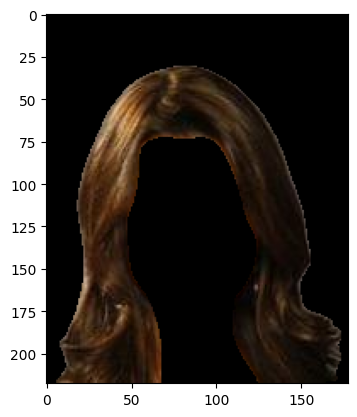

Average Color (RGB): (54, 35, 21)
Dominant Color (RGB): (32, 19, 9)
Color Comparison Results:
black - Avg Distance: 21.578191001084278, Dominant Distance: 11.304547851028433
brown - Avg Distance: 14.530967853401846, Dominant Distance: 23.984587947500298
dark_brown - Avg Distance: 5.3689758701317345, Dominant Distance: 8.867832203756121
blonde - Avg Distance: 56.669452067294316, Dominant Distance: 66.74814707554434
dark_blonde - Avg Distance: 40.849907598611814, Dominant Distance: 51.17342960185563
red - Avg Distance: 29.295635615215744, Dominant Distance: 35.9153480197537
grey - Avg Distance: 23.89261848354574, Dominant Distance: 28.66164873816407
The closest color classification is: dark_brown
Processing image: 000098.jpg


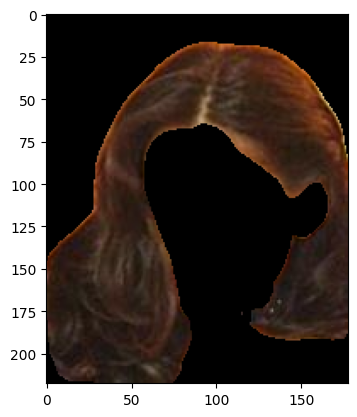

Average Color (RGB): (66, 41, 27)
Dominant Color (RGB): (49, 31, 23)
Color Comparison Results:
black - Avg Distance: 25.76507195809512, Dominant Distance: 18.104453033310367
brown - Avg Distance: 10.614981287520186, Dominant Distance: 16.74933179999641
dark_brown - Avg Distance: 7.8920891429099935, Dominant Distance: 2.7121371899166795
blonde - Avg Distance: 53.18386991452986, Dominant Distance: 60.01613489064589
dark_blonde - Avg Distance: 37.551599404229314, Dominant Distance: 44.70447007139896
red - Avg Distance: 25.772378831814724, Dominant Distance: 30.6804529227189
grey - Avg Distance: 22.78993913855909, Dominant Distance: 23.750410438150897
The closest color classification is: dark_brown
Processing image: 000172.jpg


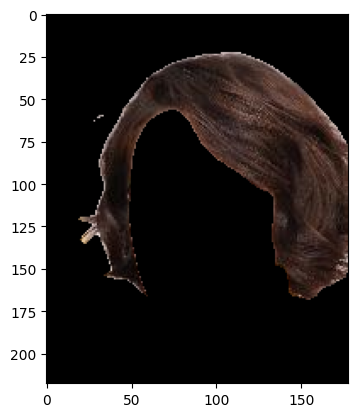

Average Color (RGB): (64, 45, 39)
Dominant Color (RGB): (44, 28, 23)
Color Comparison Results:
black - Avg Distance: 23.10050403180942, Dominant Distance: 15.532588982183082
brown - Avg Distance: 11.15707098830904, Dominant Distance: 19.048289364398787
dark_brown - Avg Distance: 4.784673825303588, Dominant Distance: 3.9550689066809865
blonde - Avg Distance: 54.8185373737695, Dominant Distance: 62.495868124831425
dark_blonde - Avg Distance: 40.62957020211184, Dominant Distance: 47.41888417410445
red - Avg Distance: 29.895093164514506, Dominant Distance: 32.53913684579096
grey - Avg Distance: 17.566714310458707, Dominant Distance: 24.322981106037982
The closest color classification is: dark_brown
Processing image: 000026.jpg


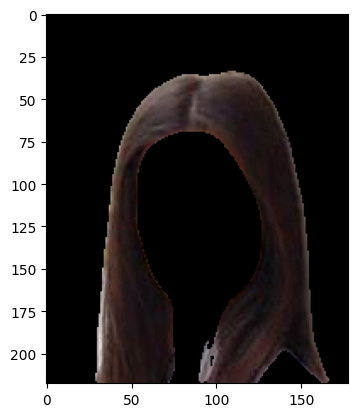

Average Color (RGB): (51, 37, 36)
Dominant Color (RGB): (33, 21, 21)
Color Comparison Results:
black - Avg Distance: 17.798879729259625, Dominant Distance: 10.546073604539744
brown - Avg Distance: 17.067571902066177, Dominant Distance: 24.373513136025654
dark_brown - Avg Distance: 4.454620266326261, Dominant Distance: 9.330880347126032
blonde - Avg Distance: 60.43648515254671, Dominant Distance: 67.8655433851178
dark_blonde - Avg Distance: 46.44258224453046, Dominant Distance: 53.09156156108709
red - Avg Distance: 33.583664306783284, Dominant Distance: 36.689976610904445
grey - Avg Distance: 19.55028064052613, Dominant Distance: 27.012015204804797
The closest color classification is: dark_brown
Processing image: 000142.jpg


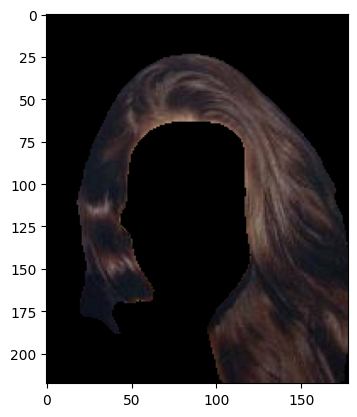

Average Color (RGB): (54, 43, 45)
Dominant Color (RGB): (31, 27, 32)
Color Comparison Results:
black - Avg Distance: 19.594626044320947, Dominant Distance: 11.217899391633916
brown - Avg Distance: 17.15751957010299, Dominant Distance: 25.9011606353745
dark_brown - Avg Distance: 7.692208673732952, Dominant Distance: 12.208231819050175
blonde - Avg Distance: 59.66937376603608, Dominant Distance: 68.52581436353991
dark_blonde - Avg Distance: 46.54298037698434, Dominant Distance: 54.83692493677195
red - Avg Distance: 35.402703260893766, Dominant Distance: 40.911310694961465
grey - Avg Distance: 16.58603834426231, Dominant Distance: 24.411894942491053
The closest color classification is: dark_brown
Processing image: 00333.jpg


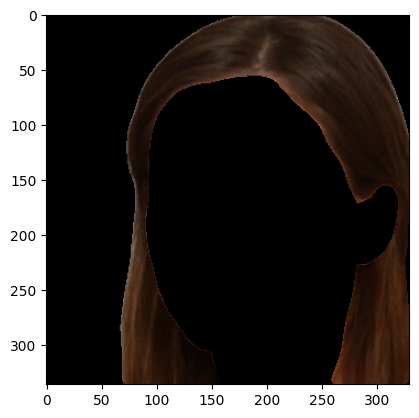

Average Color (RGB): (49, 29, 18)
Dominant Color (RGB): (34, 18, 9)
Color Comparison Results:
black - Avg Distance: 19.22802021331996, Dominant Distance: 12.274225094741384
brown - Avg Distance: 16.96532558153654, Dominant Distance: 23.64022010111754
dark_brown - Avg Distance: 5.027847676078794, Dominant Distance: 8.775435545978102
blonde - Avg Distance: 59.76519820040607, Dominant Distance: 66.78517822082252
dark_blonde - Avg Distance: 43.981688161813096, Dominant Distance: 51.179005695471226
red - Avg Distance: 29.399934310687406, Dominant Distance: 34.39322646785016
grey - Avg Distance: 25.601174736419942, Dominant Distance: 29.059058000614595
The closest color classification is: dark_brown
Processing folder: Dark Blonde
Processing image: 00066.jpg


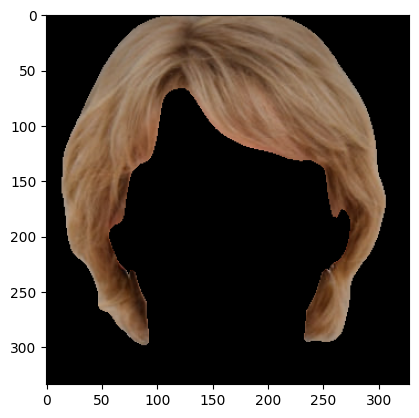

Average Color (RGB): (138, 103, 76)
Dominant Color (RGB): (157, 126, 99)
Color Comparison Results:
black - Avg Distance: 51.9224657622519, Dominant Distance: 58.87988765283271
brown - Avg Distance: 18.392336181319052, Dominant Distance: 26.11028439229275
dark_brown - Avg Distance: 33.46316536794887, Dominant Distance: 40.86502281063505
blonde - Avg Distance: 26.24679605288193, Dominant Distance: 20.140579606053517
dark_blonde - Avg Distance: 15.75396459785675, Dominant Distance: 16.988036659652305
red - Avg Distance: 33.7764964740402, Dominant Distance: 41.714661010813316
grey - Avg Distance: 26.07810078234306, Dominant Distance: 29.317579989560695
The closest color classification is: dark_blonde
Processing image: 000233.jpg


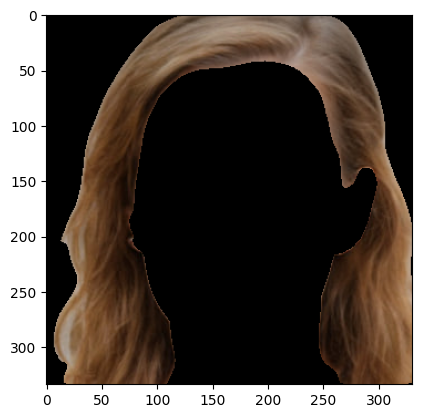

Average Color (RGB): (101, 72, 51)
Dominant Color (RGB): (107, 73, 47)
Color Comparison Results:
black - Avg Distance: 38.712918412511094, Dominant Distance: 41.80808590694902
brown - Avg Distance: 5.80326387670508, Dominant Distance: 9.566951055142148
dark_brown - Avg Distance: 20.126553905185713, Dominant Distance: 23.29275262618134
blonde - Avg Distance: 39.09408814616097, Dominant Distance: 37.036978580540335
dark_blonde - Avg Distance: 24.730669792260464, Dominant Distance: 21.832635228158285
red - Avg Distance: 27.244517727595042, Dominant Distance: 25.893156473655377
grey - Avg Distance: 19.908128688159326, Dominant Distance: 24.07076153485305
The closest color classification is: brown
Processing image: 00007778.jpg


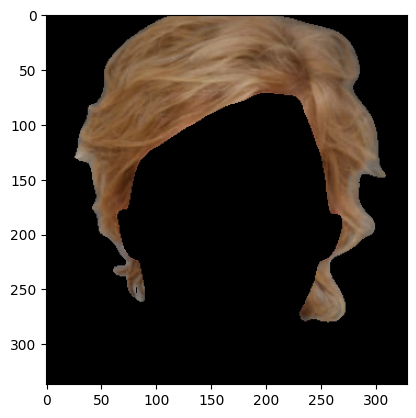

Average Color (RGB): (133, 99, 70)
Dominant Color (RGB): (133, 100, 72)
Color Comparison Results:
black - Avg Distance: 50.72702623778746, Dominant Distance: 50.599775553613384
brown - Avg Distance: 17.38712691410923, Dominant Distance: 17.279851756680916
dark_brown - Avg Distance: 32.285849203251416, Dominant Distance: 32.19279760553846
blonde - Avg Distance: 27.08256711516112, Dominant Distance: 27.105964058430082
dark_blonde - Avg Distance: 15.073387766776545, Dominant Distance: 15.568096245981206
red - Avg Distance: 33.00011823439383, Dominant Distance: 33.4514161362571
grey - Avg Distance: 26.030921165024708, Dominant Distance: 25.373153343887456
The closest color classification is: dark_blonde
Processing image: 000100.jpg


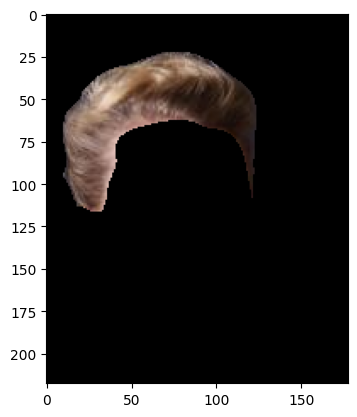

Average Color (RGB): (115, 90, 78)
Dominant Color (RGB): (122, 93, 81)
Color Comparison Results:
black - Avg Distance: 42.67452552676857, Dominant Distance: 44.75526975999663
brown - Avg Distance: 10.917971753243684, Dominant Distance: 12.305654681942881
dark_brown - Avg Distance: 24.795339411279485, Dominant Distance: 26.69891726559809
blonde - Avg Distance: 36.425433898380014, Dominant Distance: 34.998378479919474
dark_blonde - Avg Distance: 26.32796228988732, Dominant Distance: 25.44039867147123
red - Avg Distance: 32.95432478234502, Dominant Distance: 32.438357162154944
grey - Avg Distance: 14.923407184682222, Dominant Distance: 17.01346897591006
The closest color classification is: brown
Processing image: 000105.jpg


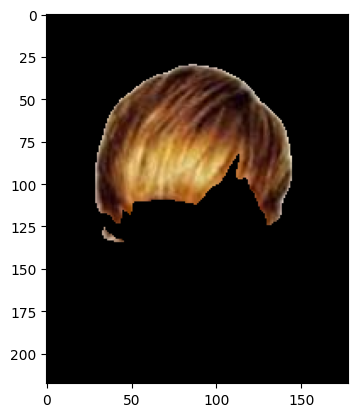

Average Color (RGB): (130, 86, 49)
Dominant Color (RGB): (75, 36, 21)
Color Comparison Results:
black - Avg Distance: 51.69525984999892, Dominant Distance: 31.408643284804114
brown - Avg Distance: 19.553789818539343, Dominant Distance: 13.56921859110931
dark_brown - Avg Distance: 33.338156827879125, Dominant Distance: 15.184456329337745
blonde - Avg Distance: 29.86386156295307, Dominant Distance: 53.02837111440591
dark_blonde - Avg Distance: 14.40112118725353, Dominant Distance: 36.948559146169394
red - Avg Distance: 28.221361788206767, Dominant Distance: 18.100400641048005
grey - Avg Distance: 32.57084530175387, Dominant Distance: 29.074280317486433
The closest color classification is: brown
Processing image: 000063.jpg


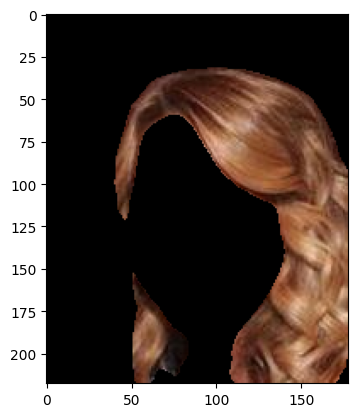

Average Color (RGB): (128, 81, 57)
Dominant Color (RGB): (137, 85, 58)
Color Comparison Results:
black - Avg Distance: 48.1218683045623, Dominant Distance: 51.683325591050064
brown - Avg Distance: 14.804118651210658, Dominant Distance: 18.535585593042995
dark_brown - Avg Distance: 29.387033609824943, Dominant Distance: 32.99323453543405
blonde - Avg Distance: 33.846180845433615, Dominant Distance: 31.87728513115442
dark_blonde - Avg Distance: 20.464980326858313, Dominant Distance: 18.991749759227613
red - Avg Distance: 24.056963946543682, Dominant Distance: 24.76861255712021
grey - Avg Distance: 28.32221076082907, Dominant Distance: 31.69756130632876
The closest color classification is: brown
Processing image: 00002333.jpg


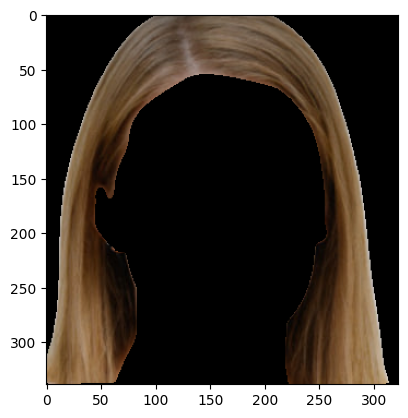

Average Color (RGB): (104, 78, 53)
Dominant Color (RGB): (109, 80, 53)
Color Comparison Results:
black - Avg Distance: 40.7697795651533, Dominant Distance: 42.73092871601294
brown - Avg Distance: 8.747208397622245, Dominant Distance: 10.378643740778097
dark_brown - Avg Distance: 22.485892488757145, Dominant Distance: 24.37161455063694
blonde - Avg Distance: 36.34330351110907, Dominant Distance: 34.76802061387238
dark_blonde - Avg Distance: 21.934746517500827, Dominant Distance: 20.122629790940373
red - Avg Distance: 29.85348821393132, Dominant Distance: 29.345899870599528
grey - Avg Distance: 20.413538604925993, Dominant Distance: 22.38227107797185
The closest color classification is: brown
Processing image: 001244.jpg


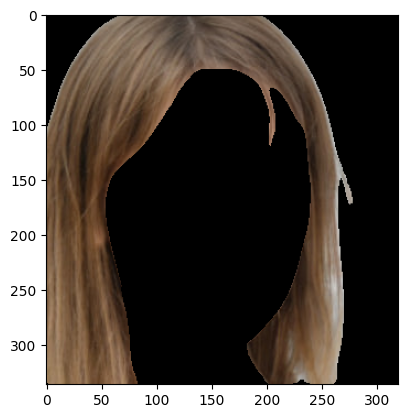

Average Color (RGB): (109, 85, 65)
Dominant Color (RGB): (115, 89, 67)
Color Comparison Results:
black - Avg Distance: 41.67199076414055, Dominant Distance: 43.94307779127731
brown - Avg Distance: 9.28668002893978, Dominant Distance: 11.2011278080598
dark_brown - Avg Distance: 23.506764510583313, Dominant Distance: 25.710393669992193
blonde - Avg Distance: 35.50940256757104, Dominant Distance: 33.29010767421623
dark_blonde - Avg Distance: 23.085835033415986, Dominant Distance: 21.0440515385737
red - Avg Distance: 31.91956290130721, Dominant Distance: 32.2079112825373
grey - Avg Distance: 17.317047260586403, Dominant Distance: 19.18478349207856
The closest color classification is: brown
Processing image: 0009988.jpg


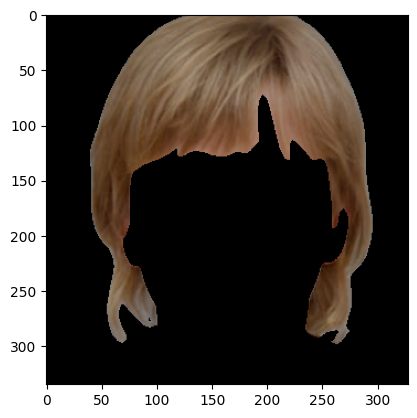

Average Color (RGB): (116, 88, 64)
Dominant Color (RGB): (139, 114, 93)
Color Comparison Results:
black - Avg Distance: 44.47435005028428, Dominant Distance: 52.589406726804036
brown - Avg Distance: 11.502968212092457, Dominant Distance: 20.519681764265183
dark_brown - Avg Distance: 26.12905221162055, Dominant Distance: 34.82543601805122
blonde - Avg Distance: 32.793512716266825, Dominant Distance: 26.283629796190567
dark_blonde - Avg Distance: 19.91376780963901, Dominant Distance: 19.916425419046053
red - Avg Distance: 31.379671827920518, Dominant Distance: 39.2184663051802
grey - Avg Distance: 20.74237991232197, Dominant Distance: 22.71234237900559
The closest color classification is: brown
Processing image: 000001.jpg


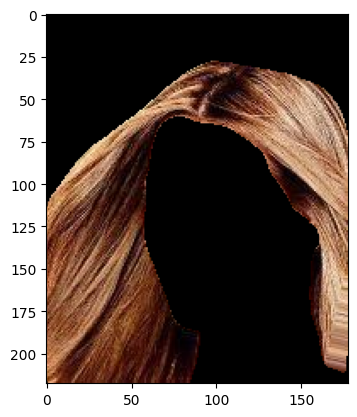

Average Color (RGB): (129, 83, 60)
Dominant Color (RGB): (61, 21, 12)
Color Comparison Results:
black - Avg Distance: 48.137146302719486, Dominant Distance: 27.299845075136208
brown - Avg Distance: 14.527629714572466, Dominant Distance: 19.088274351642255
dark_brown - Avg Distance: 29.36522217084572, Dominant Distance: 14.685588444818963
blonde - Avg Distance: 33.4062242985503, Dominant Distance: 60.37115786145704
dark_blonde - Avg Distance: 20.440865905155924, Dominant Distance: 44.383004891853844
red - Avg Distance: 24.810554178606182, Dominant Distance: 19.291581889737607
grey - Avg Distance: 27.493910522590486, Dominant Distance: 32.24311476793438
The closest color classification is: brown


In [19]:
image_dir = os.path.join(extracted_dir, "Hair_Data")
true_labels = []
predicted_labels = []

for folder_name in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_name}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, filename)
                print(f"Processing image: {filename}")
                try:
                    # Run classification and store labels in lowercase
                    predicted_label = Classify_hair(image_path, colorSpaces).lower()
                    true_labels.append(folder_name.lower())
                    predicted_labels.append(predicted_label)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")



In [23]:
from collections import Counter

# Normalize true and predicted labels
true_labels = [label.strip().replace("_", " ").lower() for label in true_labels]
predicted_labels = [label.strip().replace("_", " ").lower() for label in predicted_labels]

# Check data distribution
print("True label distribution:", Counter(true_labels))
print("Predicted label distribution:", Counter(predicted_labels))

# Class-wise accuracy
unique_classes = set(true_labels)
print("\nClass-wise Accuracy:")
for cls in unique_classes:
    true_count = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == cls and pred == cls)
    total_count = sum(1 for true in true_labels if true == cls)
    accuracy = true_count / total_count if total_count > 0 else 0
    print(f"Class '{cls}': {accuracy * 100:.2f}%")

# Classification report
report = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(unique_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_classes))
disp.plot(cmap="Blues", xticks_rotation="vertical")

True label distribution: Counter({'black': 13, 'blonde': 10, 'brown': 10, 'grey': 10, 'red': 10, 'dark brown': 10, 'dark blonde': 10})
Predicted label distribution: Counter({'dark brown': 21, 'brown': 18, 'black': 9, 'grey': 9, 'red': 7, 'blonde': 5, 'dark blonde': 4})

Class-wise Accuracy:
Class 'dark brown': 90.00%
Class 'blonde': 50.00%
Class 'red': 70.00%
Class 'black': 69.23%
Class 'dark blonde': 20.00%
Class 'brown': 30.00%
Class 'grey': 80.00%

Classification Report:
              precision    recall  f1-score    support
black          1.000000  0.692308  0.818182  13.000000
blonde         1.000000  0.500000  0.666667  10.000000
brown          0.166667  0.300000  0.214286  10.000000
dark blonde    0.500000  0.200000  0.285714  10.000000
dark brown     0.428571  0.900000  0.580645  10.000000
grey           0.888889  0.800000  0.842105  10.000000
red            1.000000  0.700000  0.823529  10.000000
accuracy       0.589041  0.589041  0.589041   0.589041
macro avg      0.712018  0

NameError: name 'confusion_matrix' is not defined

In [24]:
# Save results to a DataFrame and export as CSV
results_df = pd.DataFrame({
    'Image': [os.path.basename(path) for path in true_labels],
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})
results_df.to_csv('/content/LAB_results.csv', index=False)